# 0.0 Imports

In [2]:
import pandas                            as pd
import inflection
import math
import numpy                             as np
import seaborn                           as sns
import pickle
import warnings
import random
import swifter
import requests

from matplotlib            import pyplot as plt

import datetime
from matplotlib.gridspec   import GridSpec
from tabulate              import tabulate

from scipy                 import stats  as ss
from cramer                import cramer

from boruta import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
import xgboost                           as xgb

from sklearn.ensemble      import RandomForestRegressor


from IPython.core.display  import HTML

warnings.filterwarnings('ignore')

## 0.1 Helper Function

In [22]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )


def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

def mean_percentage_error(Y, yhat):
    return np.mean( ((Y - yhat)/ Y))

def mean_absolute_percentage_error(Y, yhat):
    return np.mean(np.abs ((Y - yhat)/ Y))


def ml_error(model_name, Y, yhat):

    mae = mean_absolute_error(Y, yhat)
    mape = mean_absolute_percentage_error(Y, yhat)
    rmse = np.sqrt(mean_squared_error(Y, yhat))

    return pd.DataFrame ({'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0])
    

def cross_validation(x_training, kfold, model_name, model, verbose=False):

    mae_list = []
    mape_list = []
    rmse_list = []


    for k in reversed(range(1, kfold+1)):

        if verbose:
            print('\nKould Number: {}'.format(k))


        # #Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        #training and validation dataset
        #training

        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        #validation
        xvalidation = validation.drop([ 'date', 'sales'], axis=1)
        yvalidation = validation['sales']


         #model
        m = model.fit(xtraining, ytraining)

         #pediction
        yhat = m.predict(xvalidation)

         #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of edch Kfold iteration

        mae_list.append( m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                        'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str), 
                        'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str), 
                        'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

In [23]:
jupyter_settings()

## 0.2 loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge

df_raw = pd.merge (df_sales_raw, df_store_raw, how="left", on='Store')

# Passo 01 - Descrição dos dados

In [25]:
df1 = df_raw.copy()

## 1.1 rename columns

In [26]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename

df1.columns = cols_new

## 1.2 Data Dimensions

In [27]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [28]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 check NA

In [29]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [30]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
170411,932,7,2015-03-01,0,0,0,0,0,0,a,a,15700.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [31]:
# competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

                     
# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

# promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4:'Apr', 5: 'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0, axis=1)


In [32]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Data Types

In [33]:
#competition
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

#promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [34]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Atributes

In [35]:
# central Tendency - mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - sdt, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply(np.std)).T
d2 = pd.DataFrame( num_attributes.apply(min)).T
d3 = pd.DataFrame( num_attributes.apply(max)).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis())).T

#contatenate

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


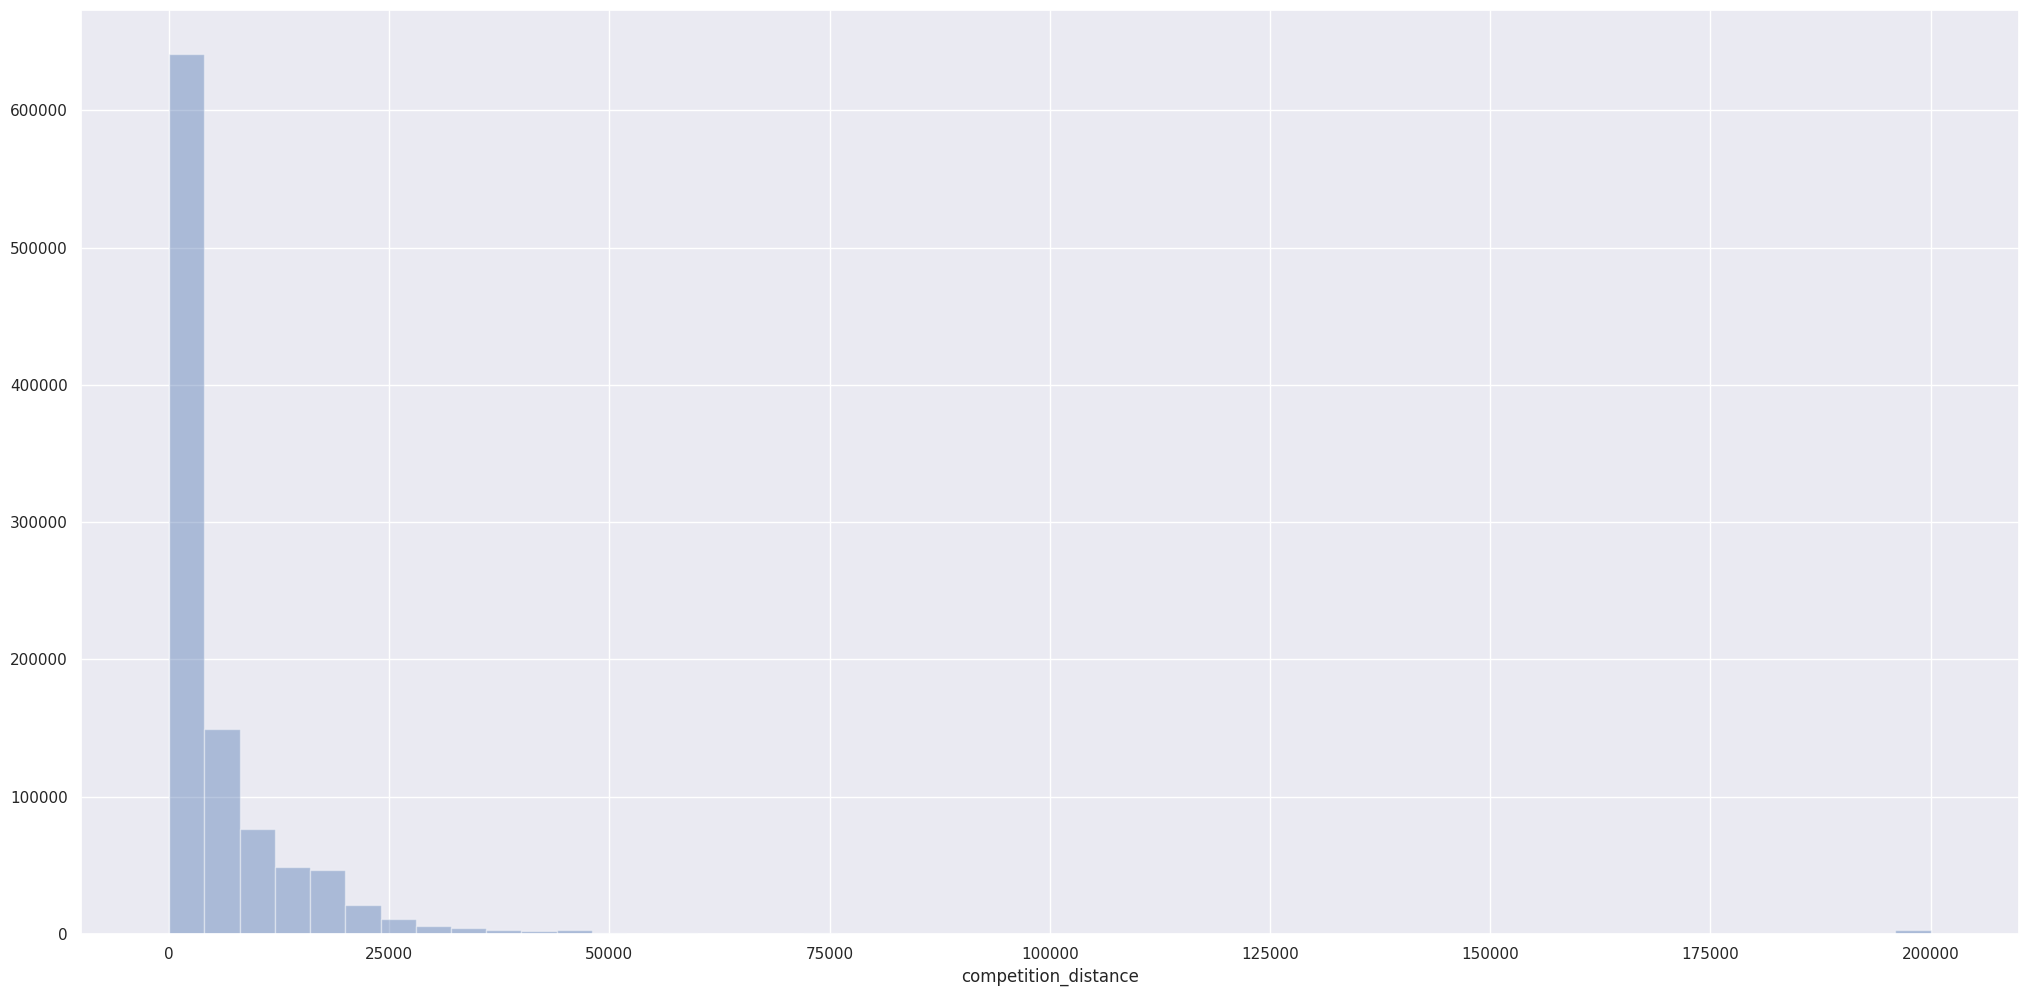

In [36]:
sns.distplot( df1['competition_distance'], kde=False );

### 1.7.2 Categorical Atributes

In [37]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

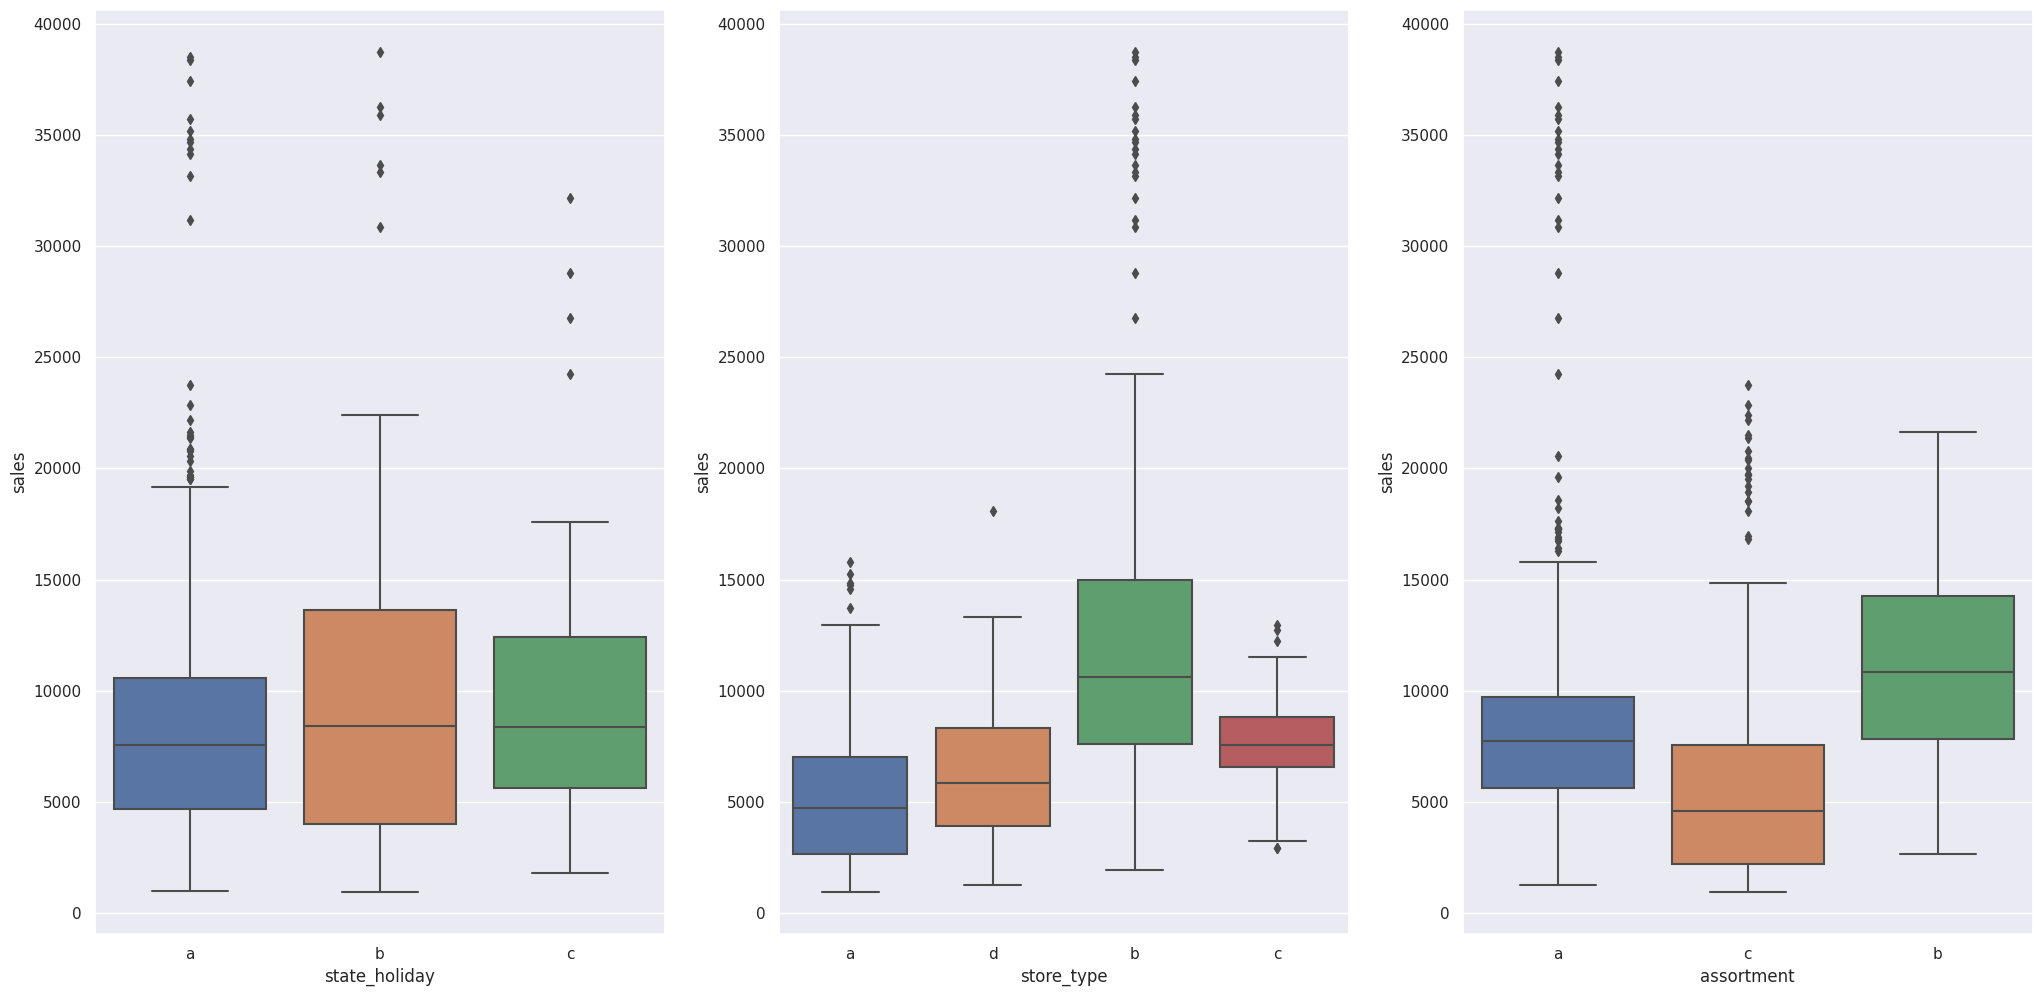

In [38]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# Passo 02 - Feature Engineering

In [39]:
df2 = df1.copy()

## 2.4 Feature Engineering


In [40]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int)
#promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days ).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day' )


# Passo 03 - Filtragem de veriáveis

In [41]:
df3 = df2.copy()

## 3.1 Filtragem de linhas

In [42]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Filtragem de colunas

In [43]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# Passo 04  - Analise exploratoria dos dados

In [44]:
df4 = df3.copy()

In [45]:
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

## 4.1 Analise univariada

### 4.1.1 Response variable

<Axes: xlabel='sales'>

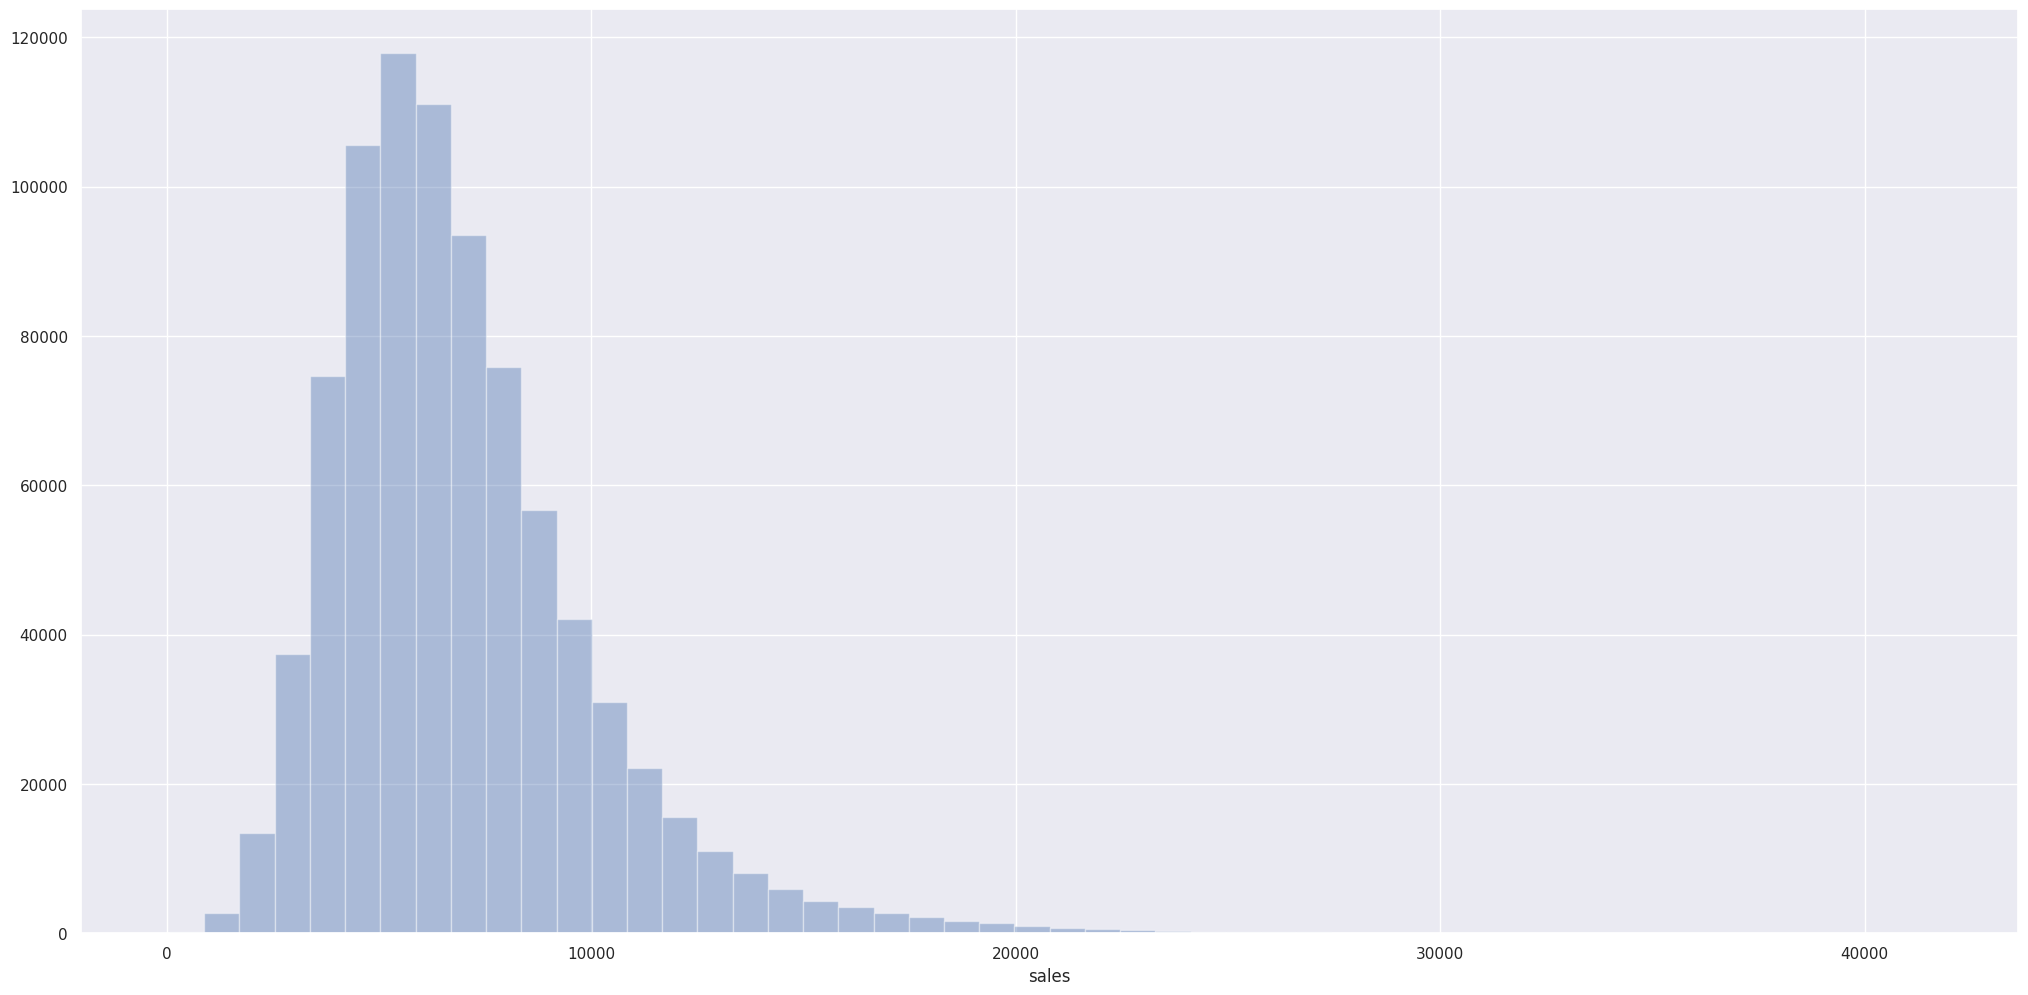

In [46]:
sns.distplot( df4['sales'], kde=False  )

### 4.1.2  Numerical variable

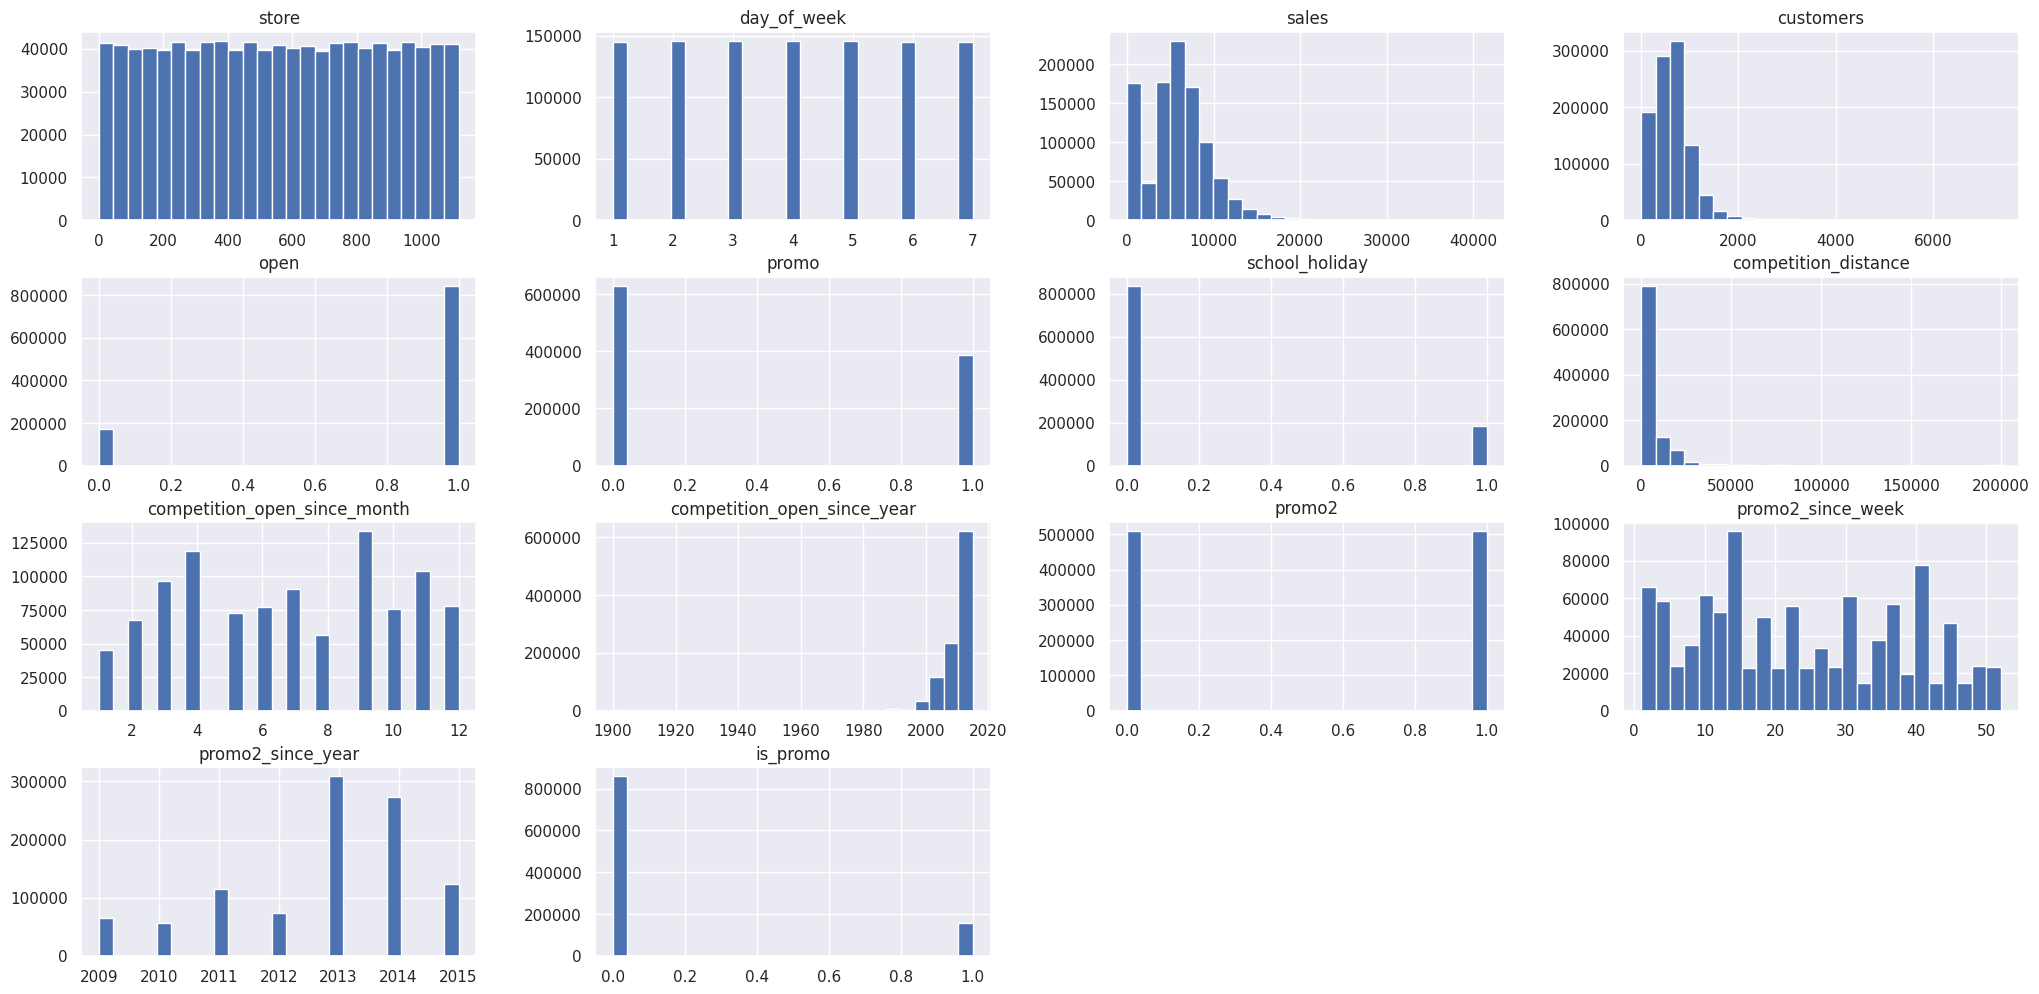

In [47]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

<Axes: xlabel='sales', ylabel='Density'>

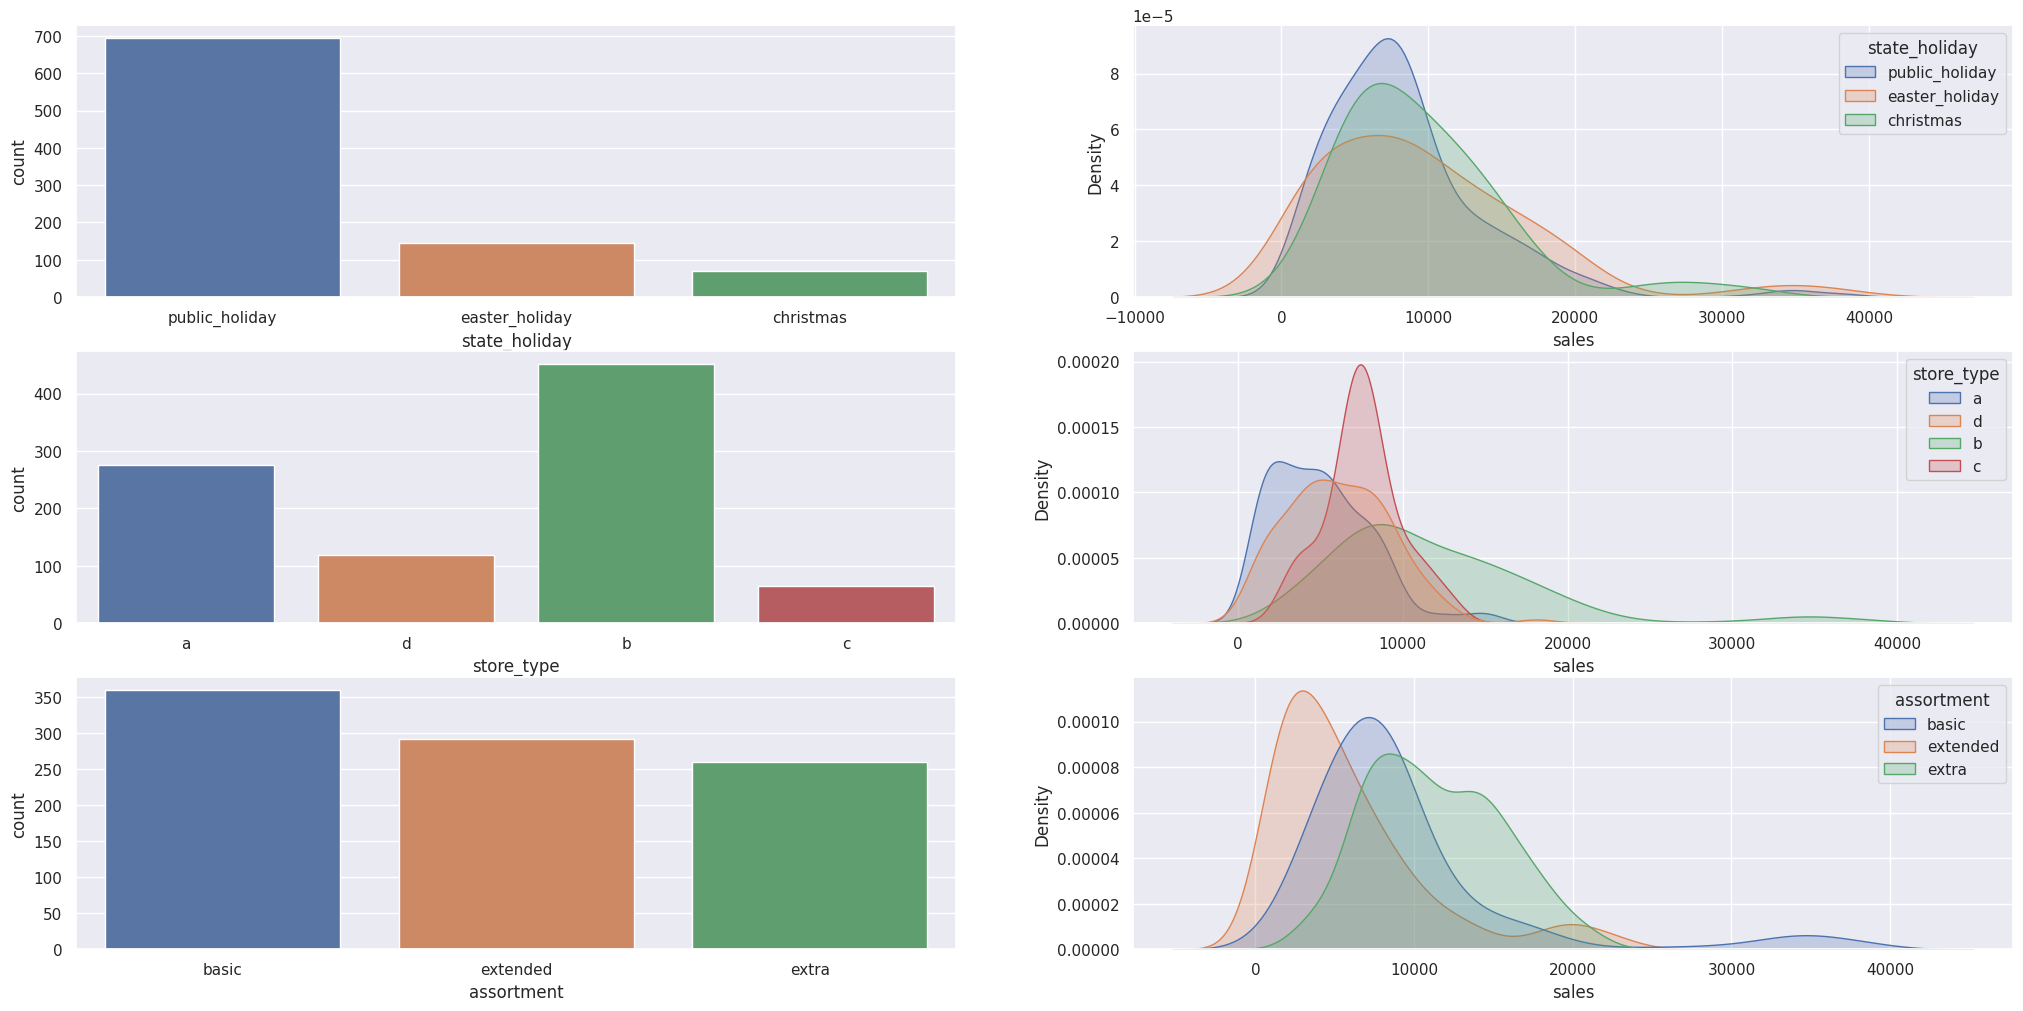

In [48]:
# # regular_day


plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(x=a['state_holiday'])

plt.subplot(3,2,2)

sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)
sns.kdeplot(x = df4[df4['state_holiday'] == 'christmas']['sales'], fill=True, hue=a['state_holiday'])

plt.subplot(3,2,3)
sns.countplot(x=a['store_type'])

plt.subplot(3,2,4)

sns.kdeplot(x = df4[df4['store_type'] == 'a']['sales'], fill=True, hue=a['store_type'])
sns.kdeplot(x = df4[df4['store_type'] == 'b']['sales'], fill=True, hue=a['store_type'])
sns.kdeplot(x = df4[df4['store_type'] == 'c']['sales'], fill=True, hue=a['store_type'])
sns.kdeplot(x = df4[df4['store_type'] == 'd']['sales'], fill=True, hue=a['store_type'])


plt.subplot(3,2,5)
sns.countplot(x=a['assortment'])

plt.subplot(3,2,6)

sns.kdeplot(x = df4[df4['assortment'] == 'extended']['sales'], fill=True, hue=a['assortment'])
sns.kdeplot(x = df4[df4['assortment'] == 'basic']['sales'], fill=True, hue=a['assortment'])
sns.kdeplot(x = df4[df4['assortment'] == 'extra']['sales'], fill=True, hue=a['assortment'])





## 4.2 Analise Bivariada

<Axes: xlabel='year_week'>

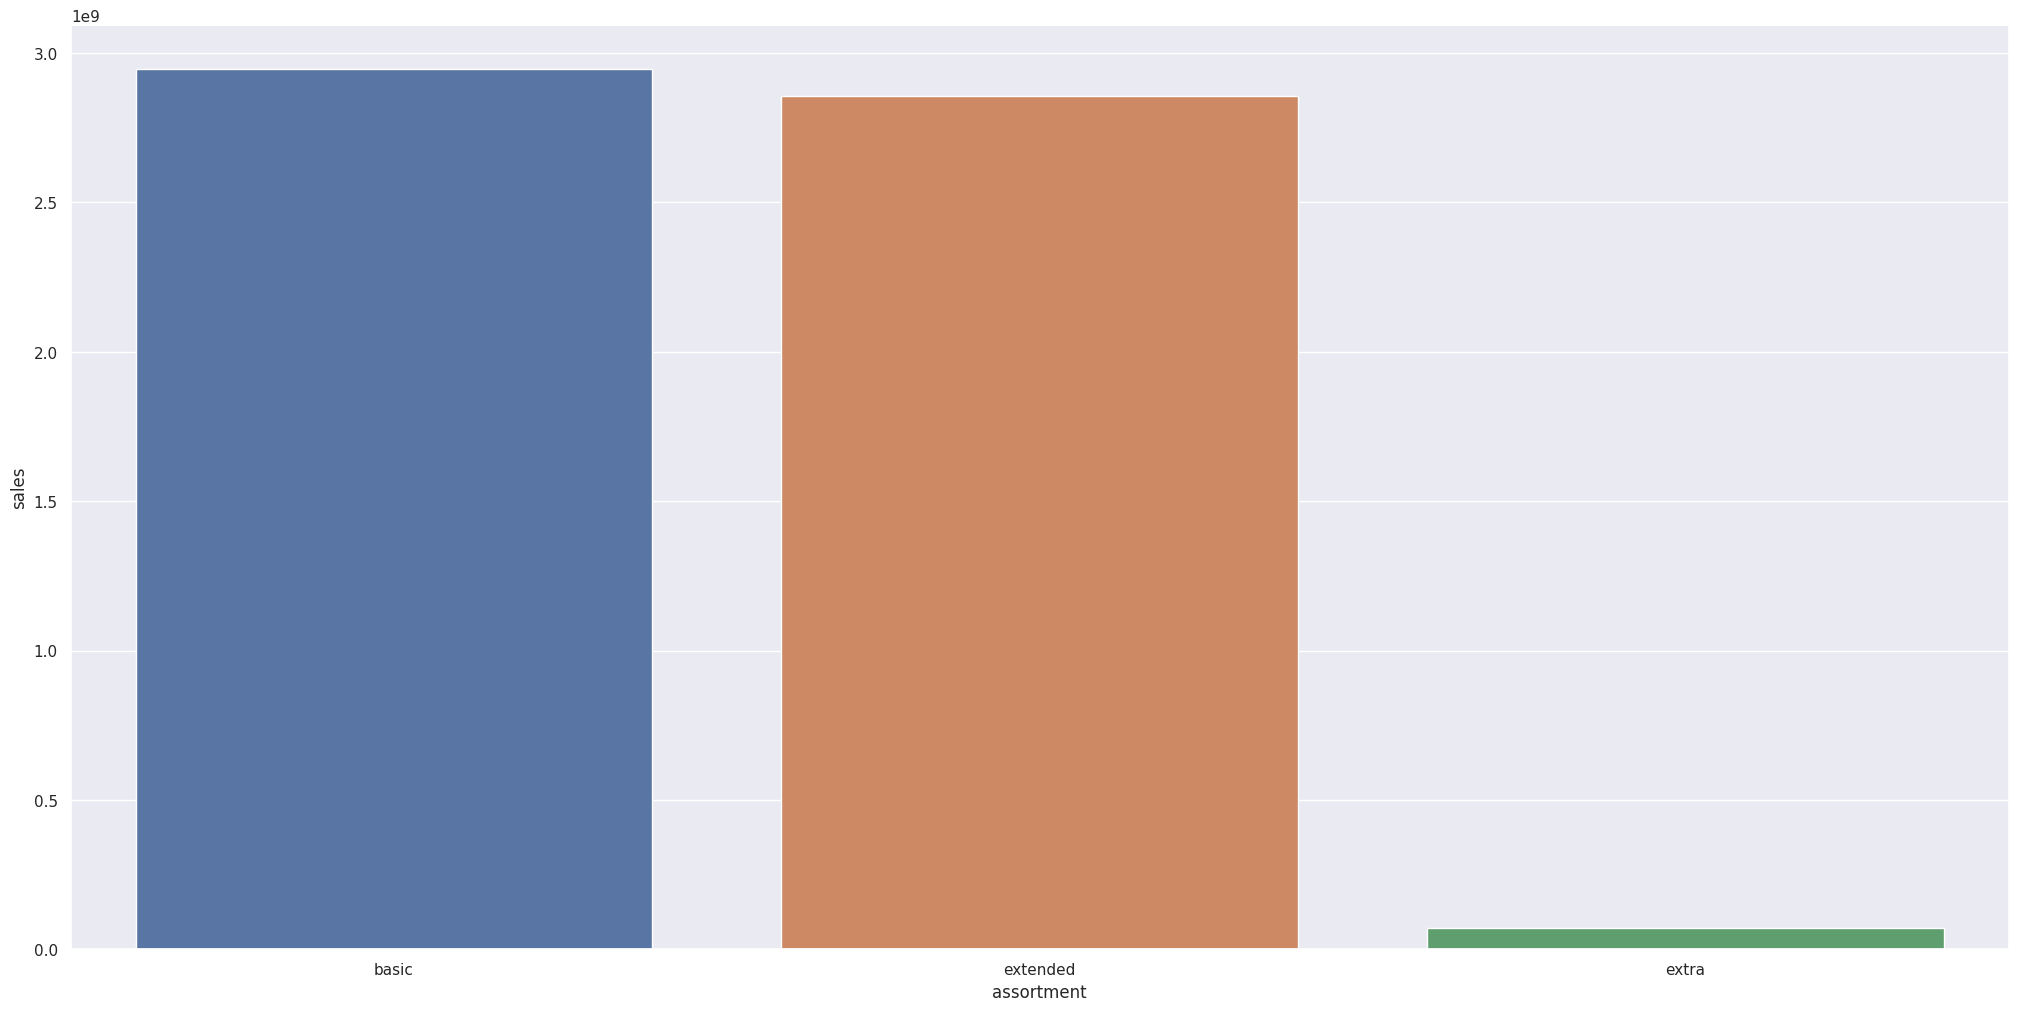

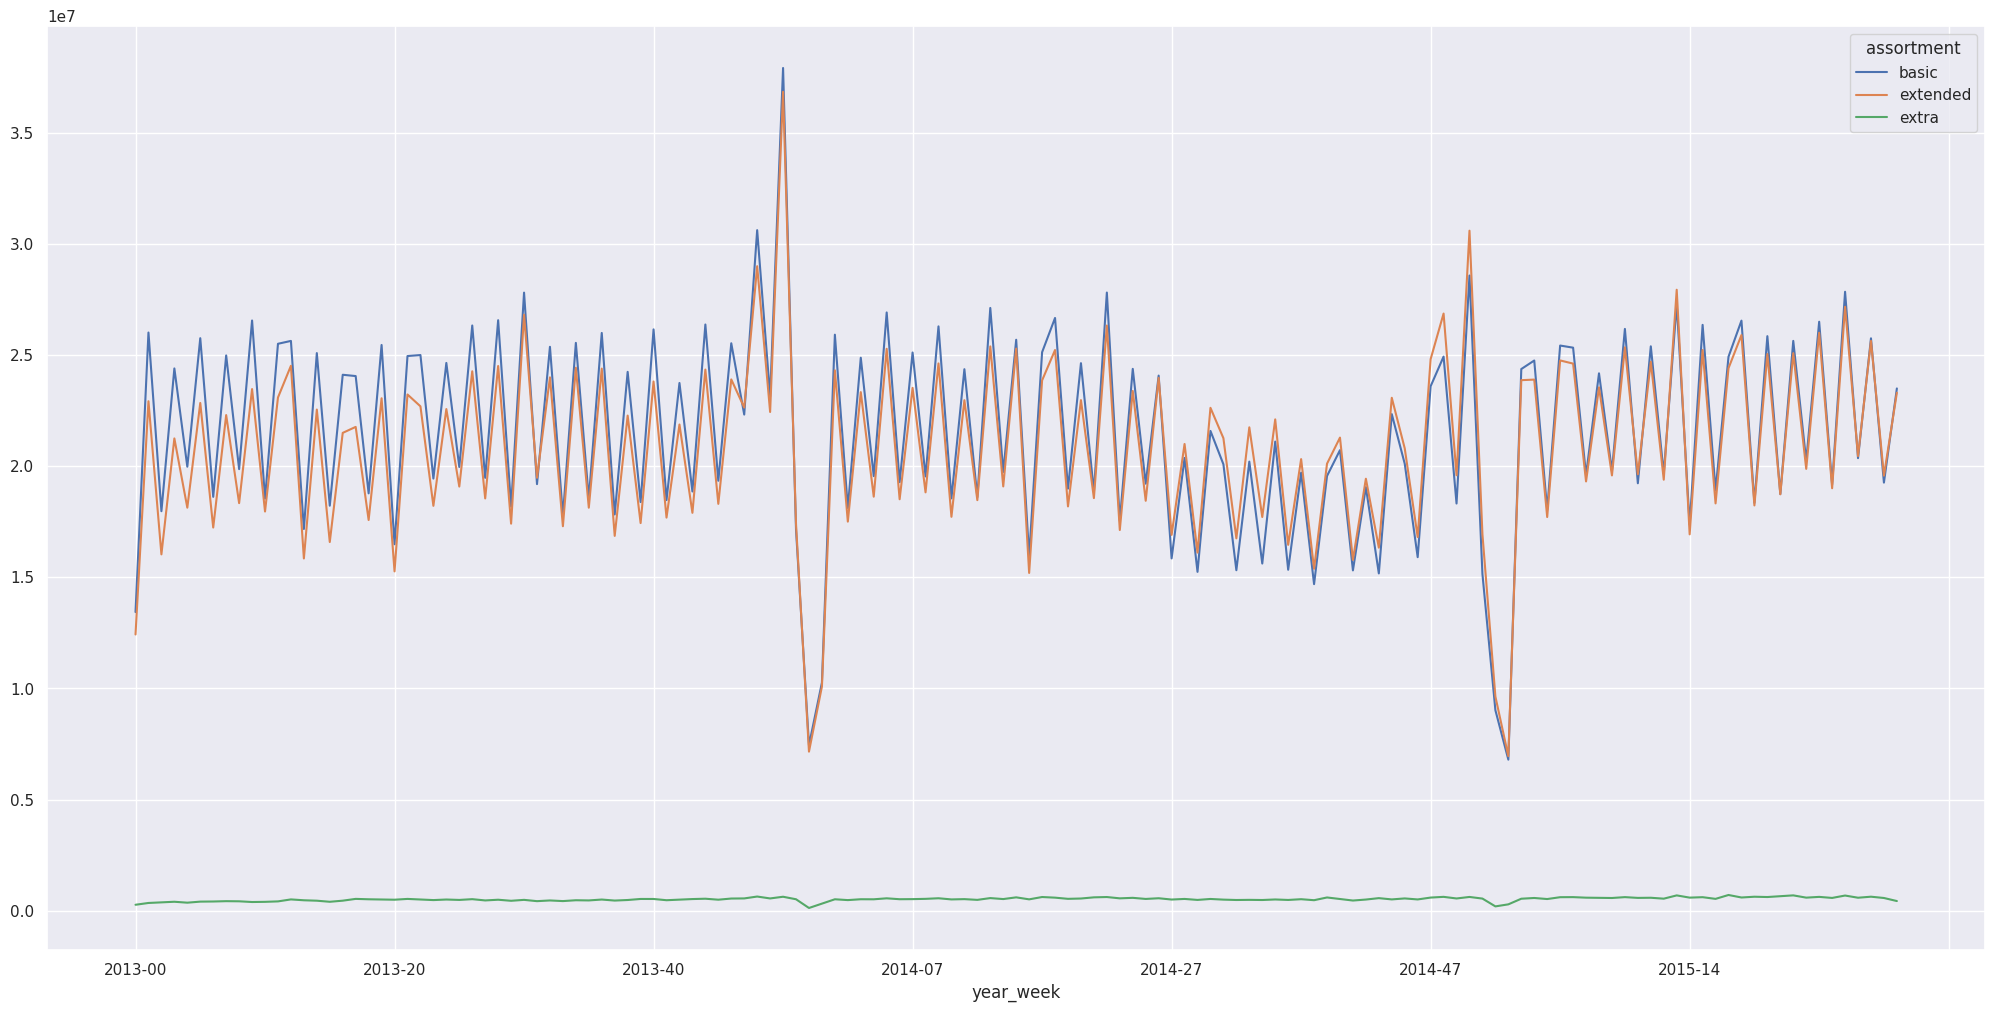

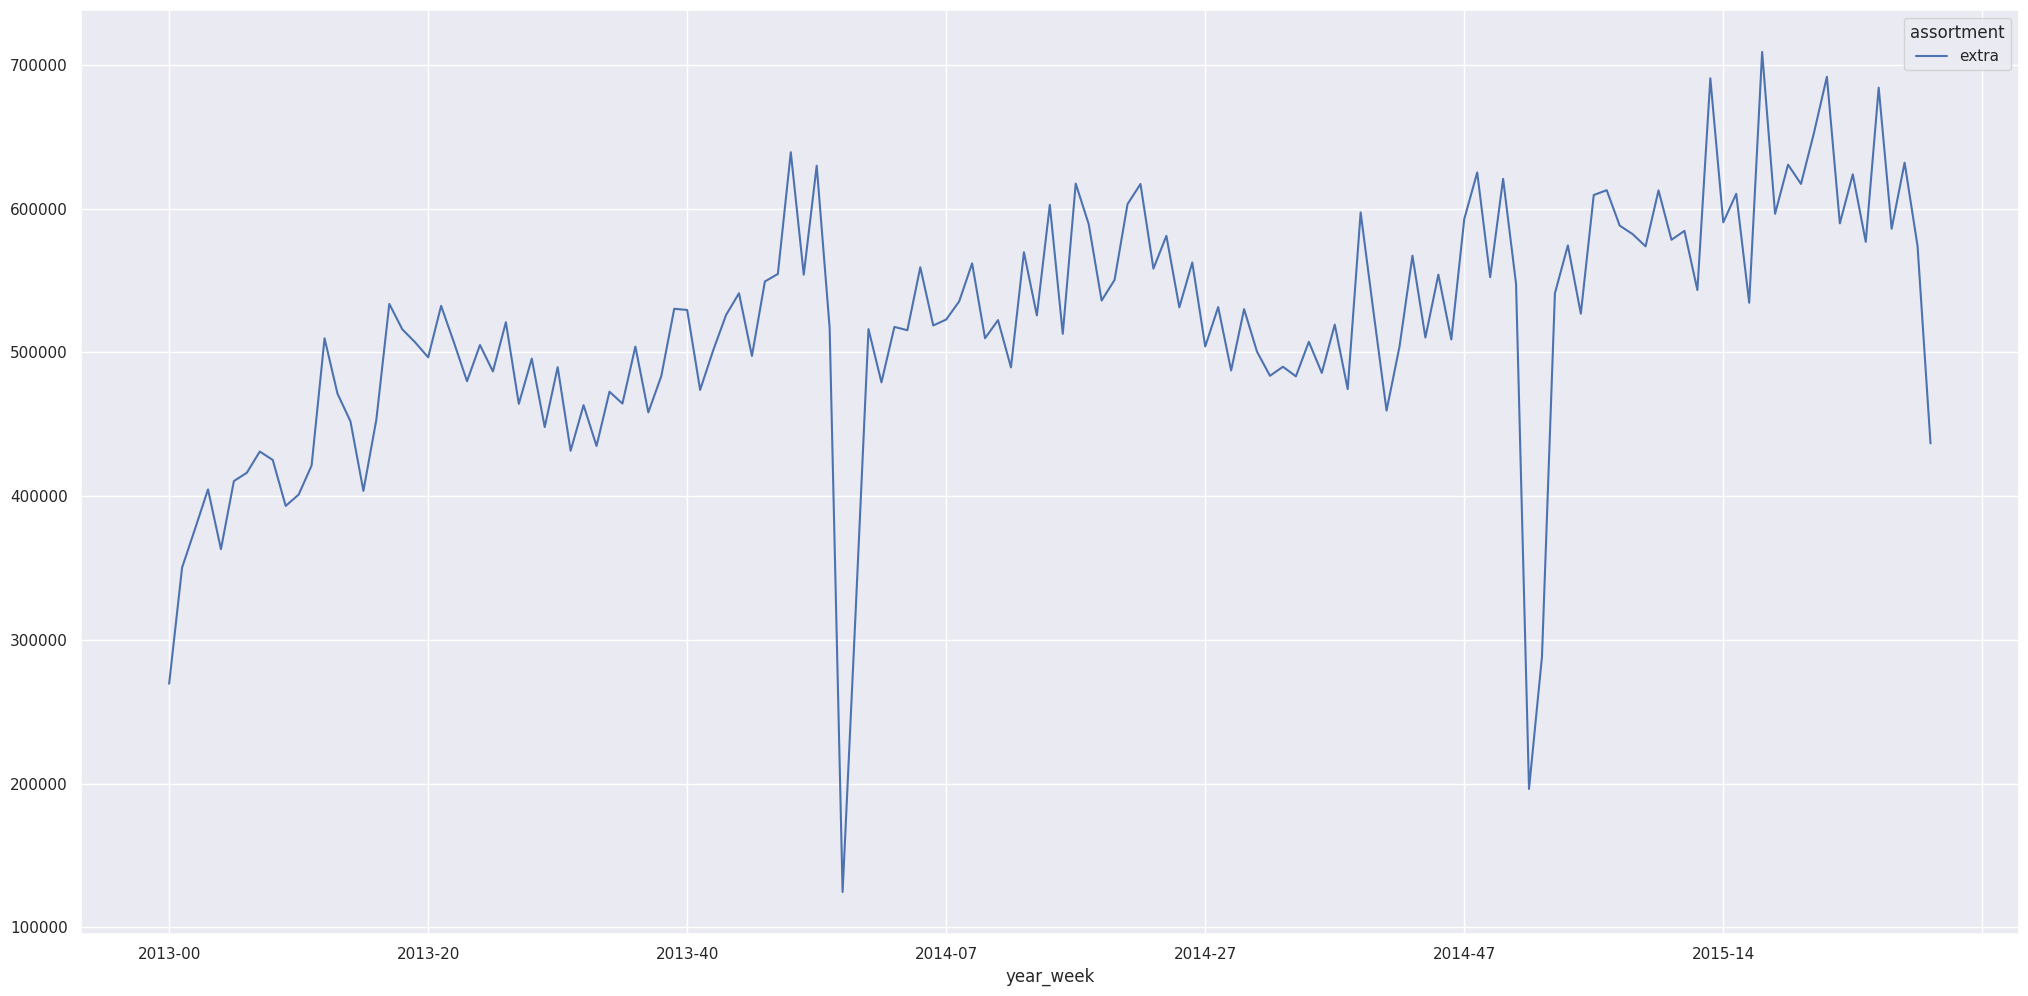

In [49]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns= 'assortment', values= 'sales').plot()

aux3 = aux2[aux2['assortment' ] =='extra']
aux3.pivot(index='year_week', columns= 'assortment', values= 'sales').plot()

### H2. lojas com compedidores mais próximos devem vender menos.

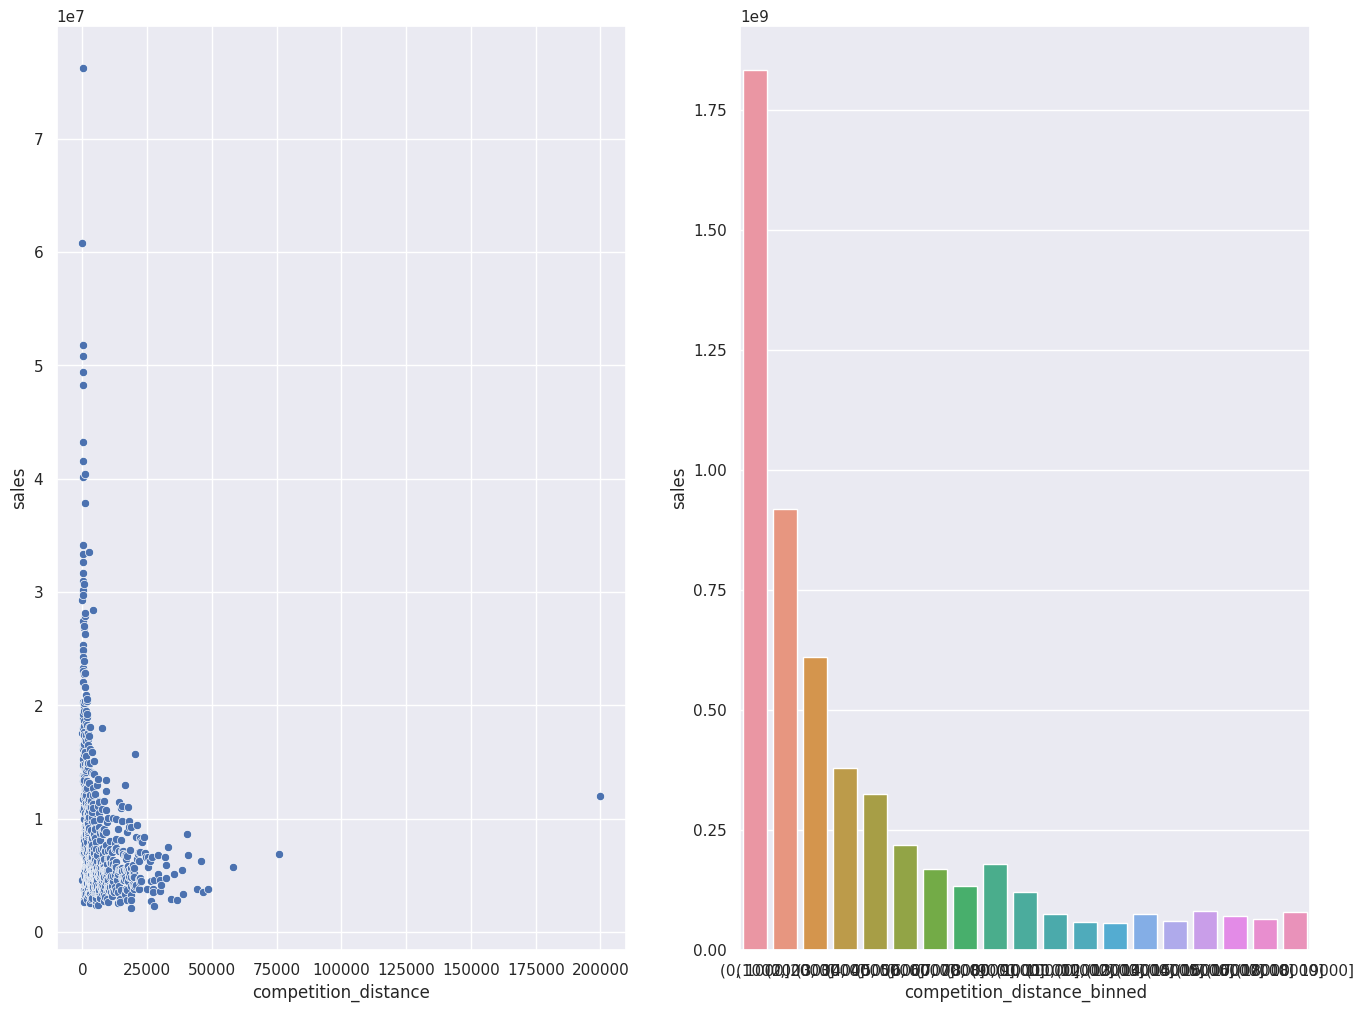

In [50]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()


plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

# plt.subplot(1,3,3)
# sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H3. Lojas com competidores à mais tempo deveriam vender menos

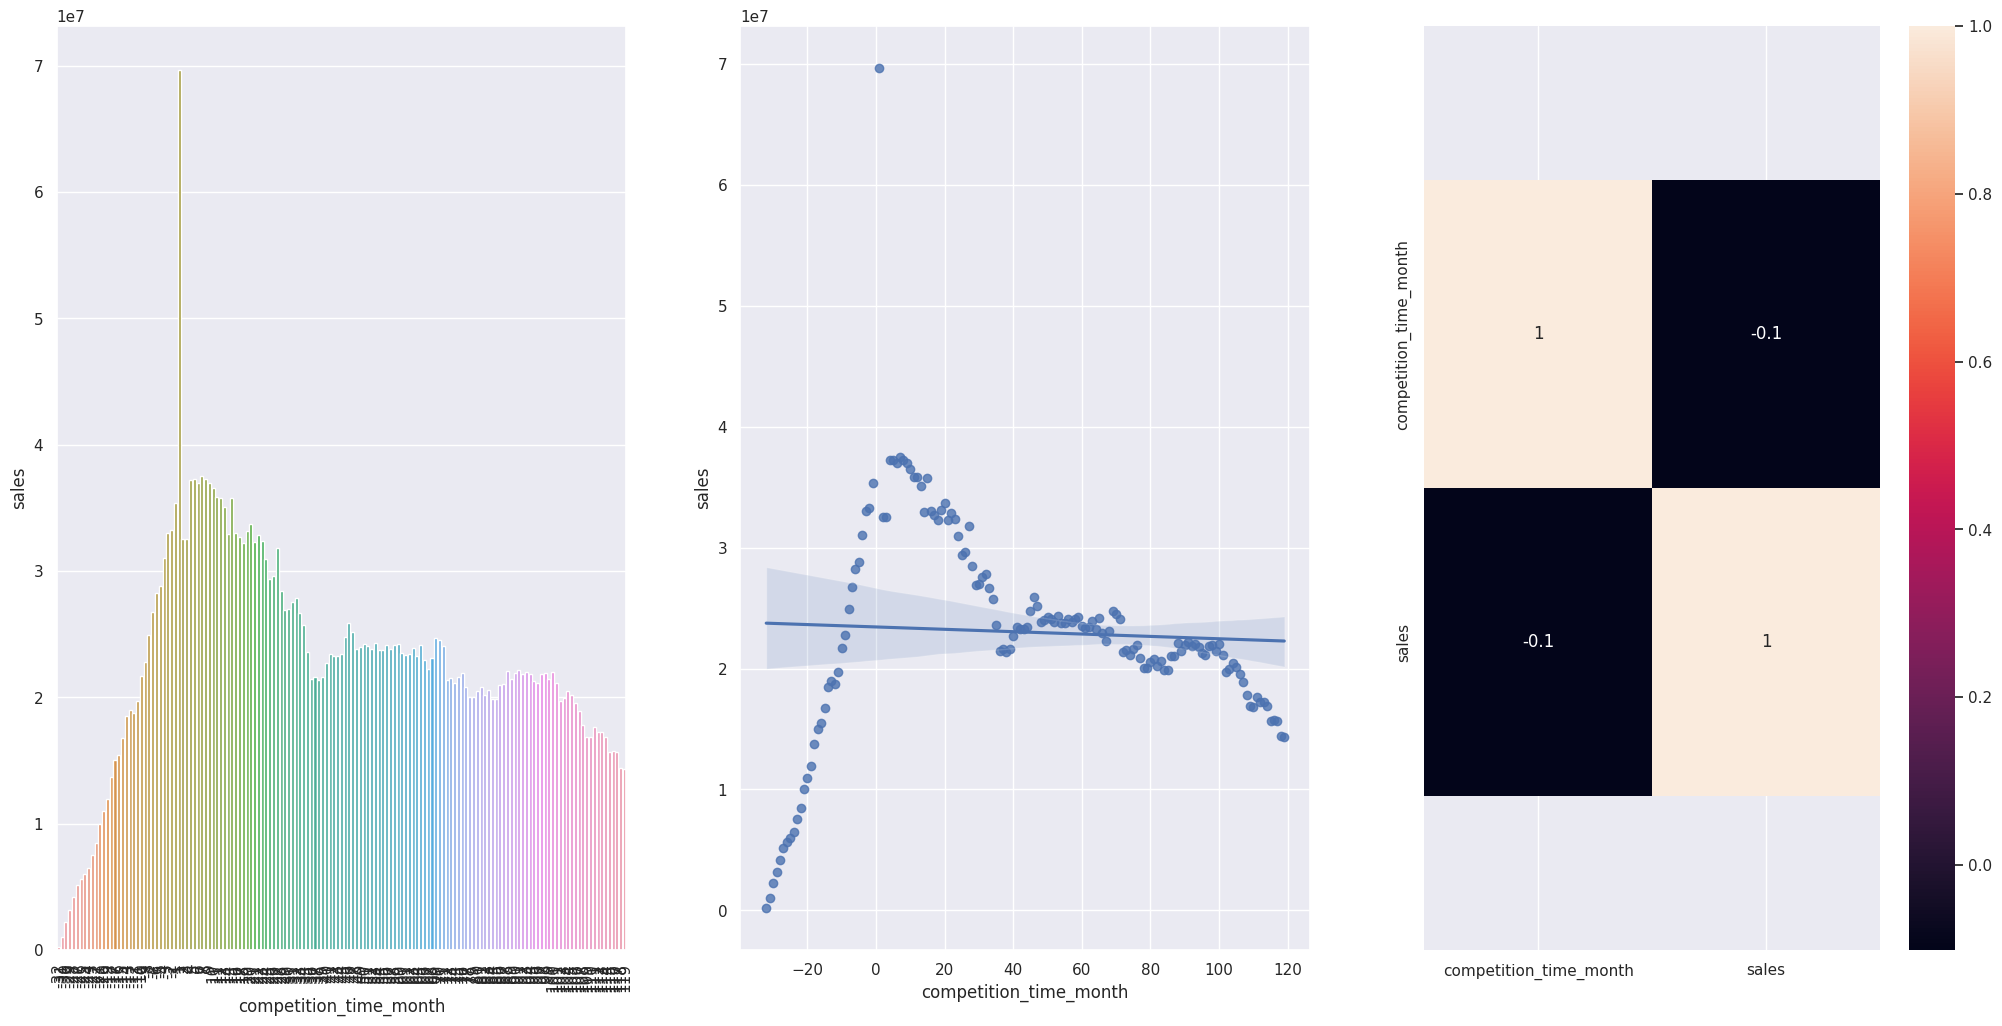

In [51]:

plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);




### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

<Axes: >

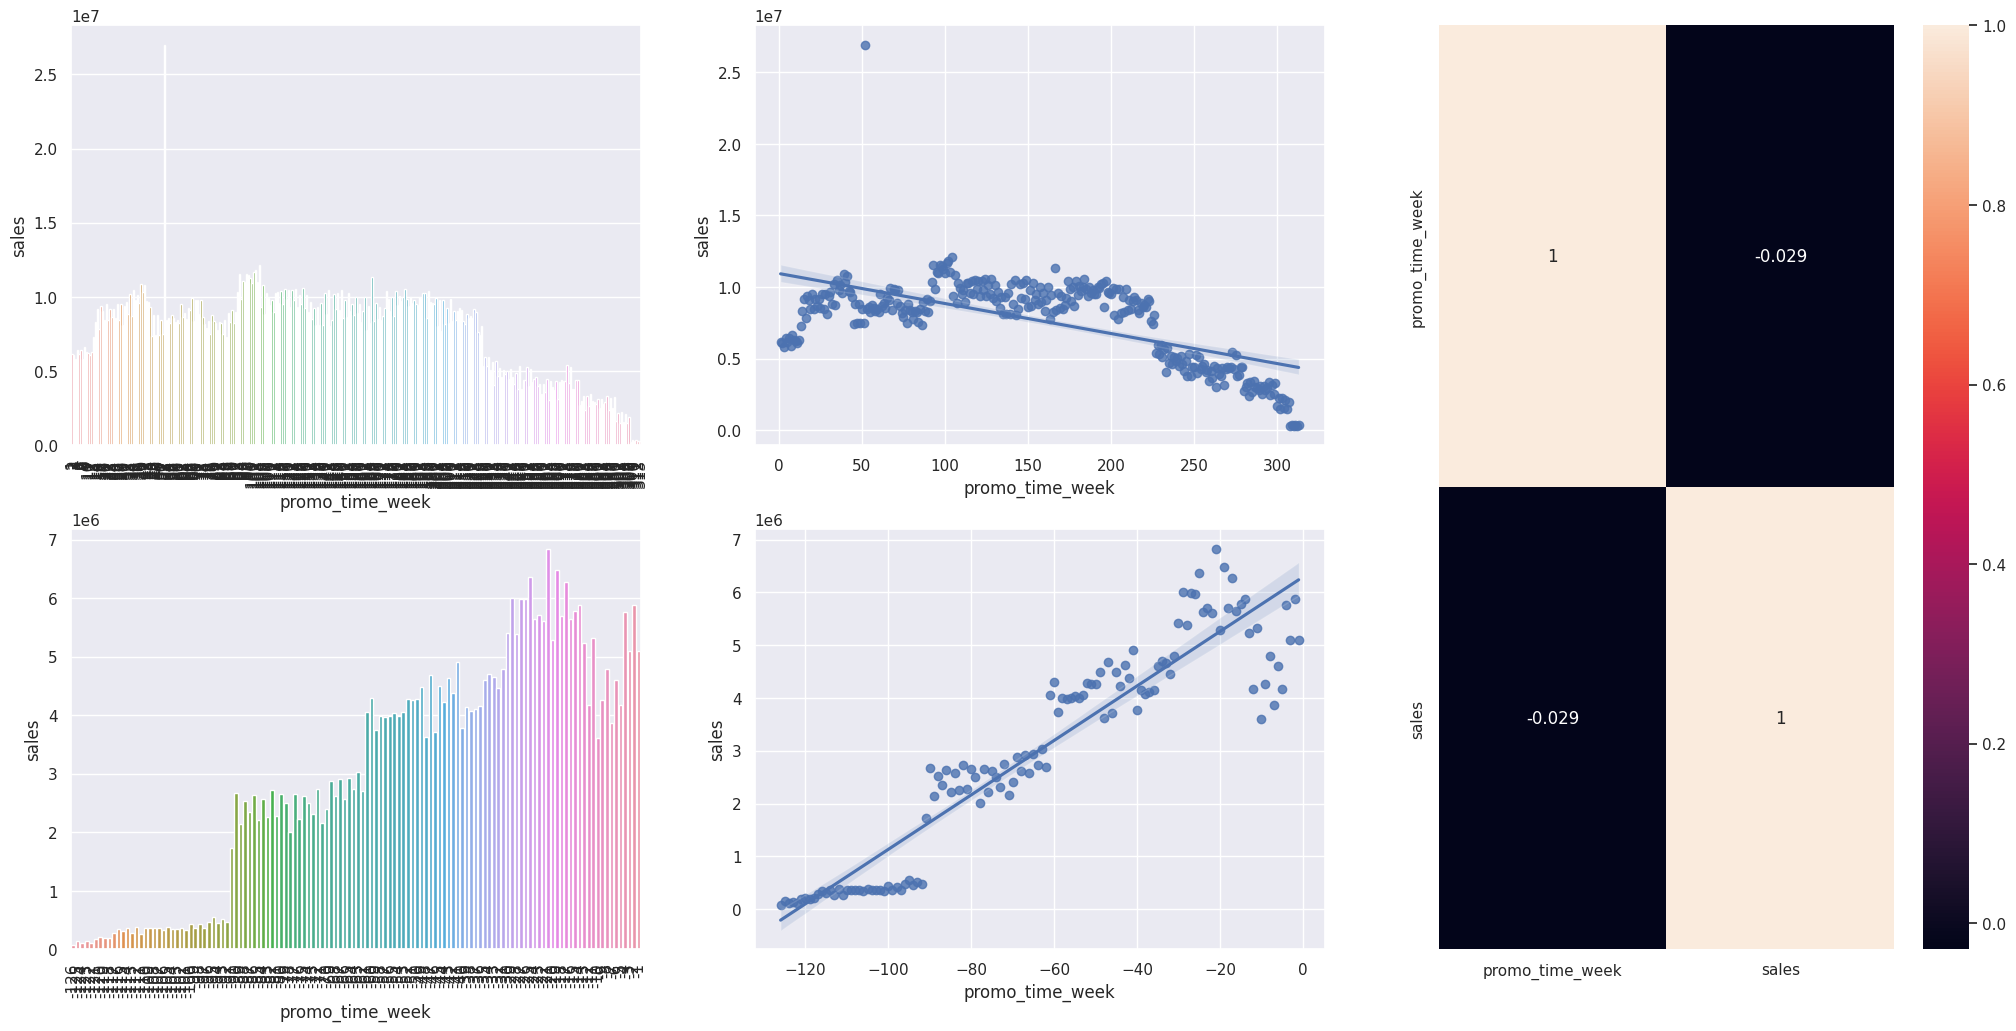

In [52]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0]
sns.barplot(x='promo_time_week', y='sales', data=aux2)
plt.xticks(rotation=90);


plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2)


plt.subplot(grid[1,0])

aux3 = aux1[aux1['promo_time_week'] < 0]
sns.barplot(x='promo_time_week', y='sales', data=aux3)
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)



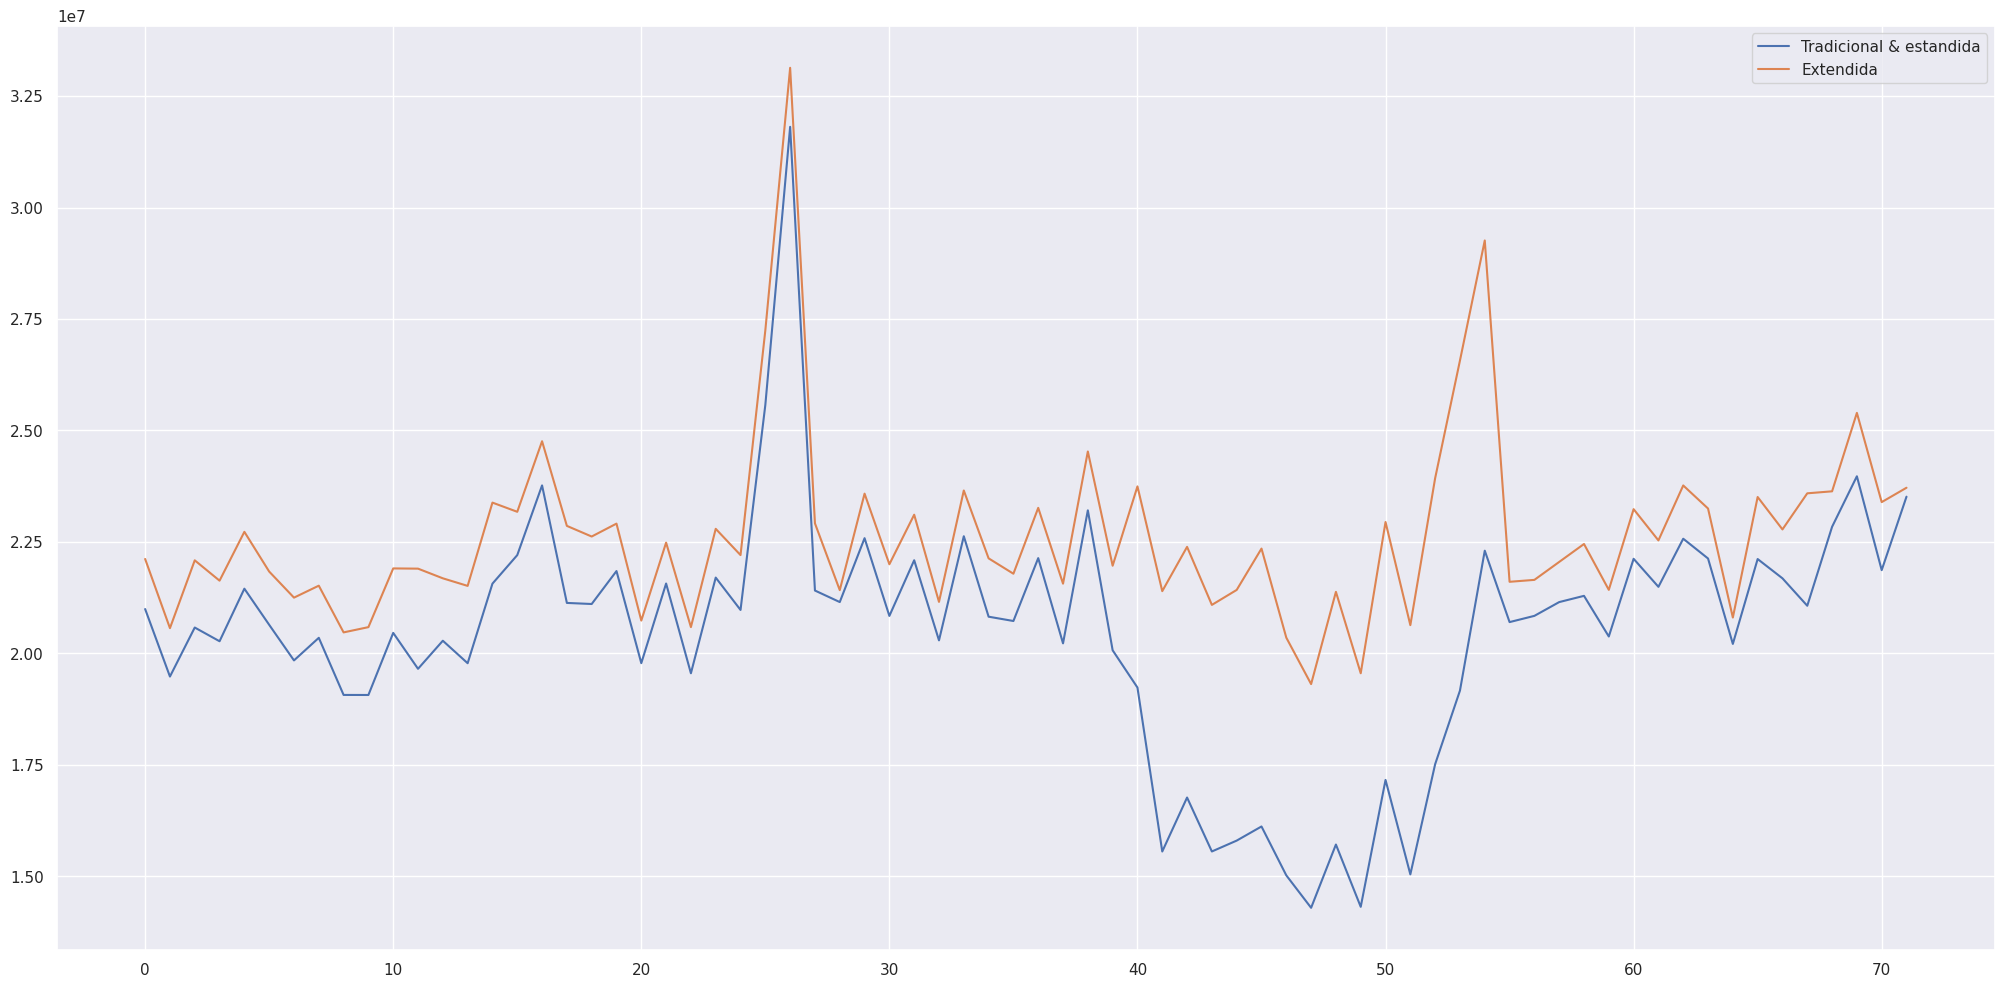

In [53]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot( ax=ax)

ax.legend(labels=['Tradicional & estandida', 'Extendida' ])

<Axes: xlabel='year', ylabel='sales'>

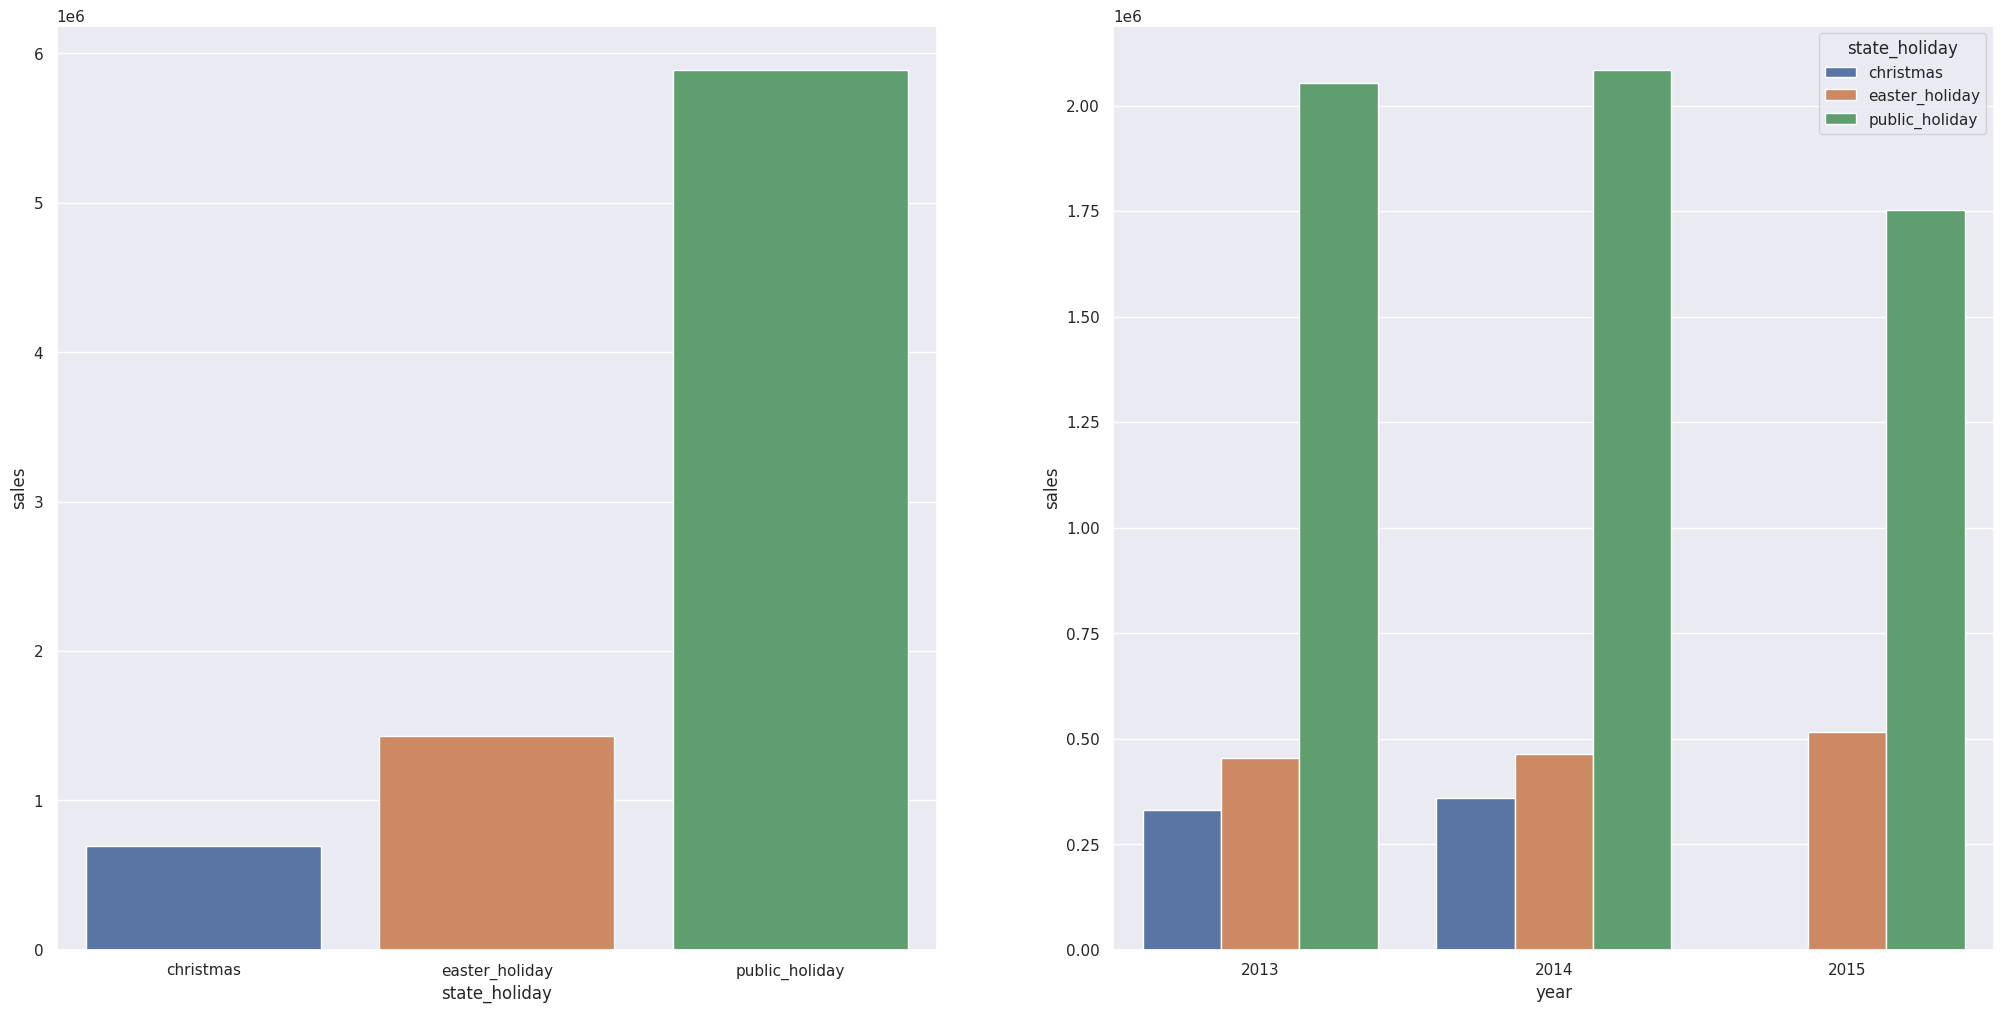

In [54]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)


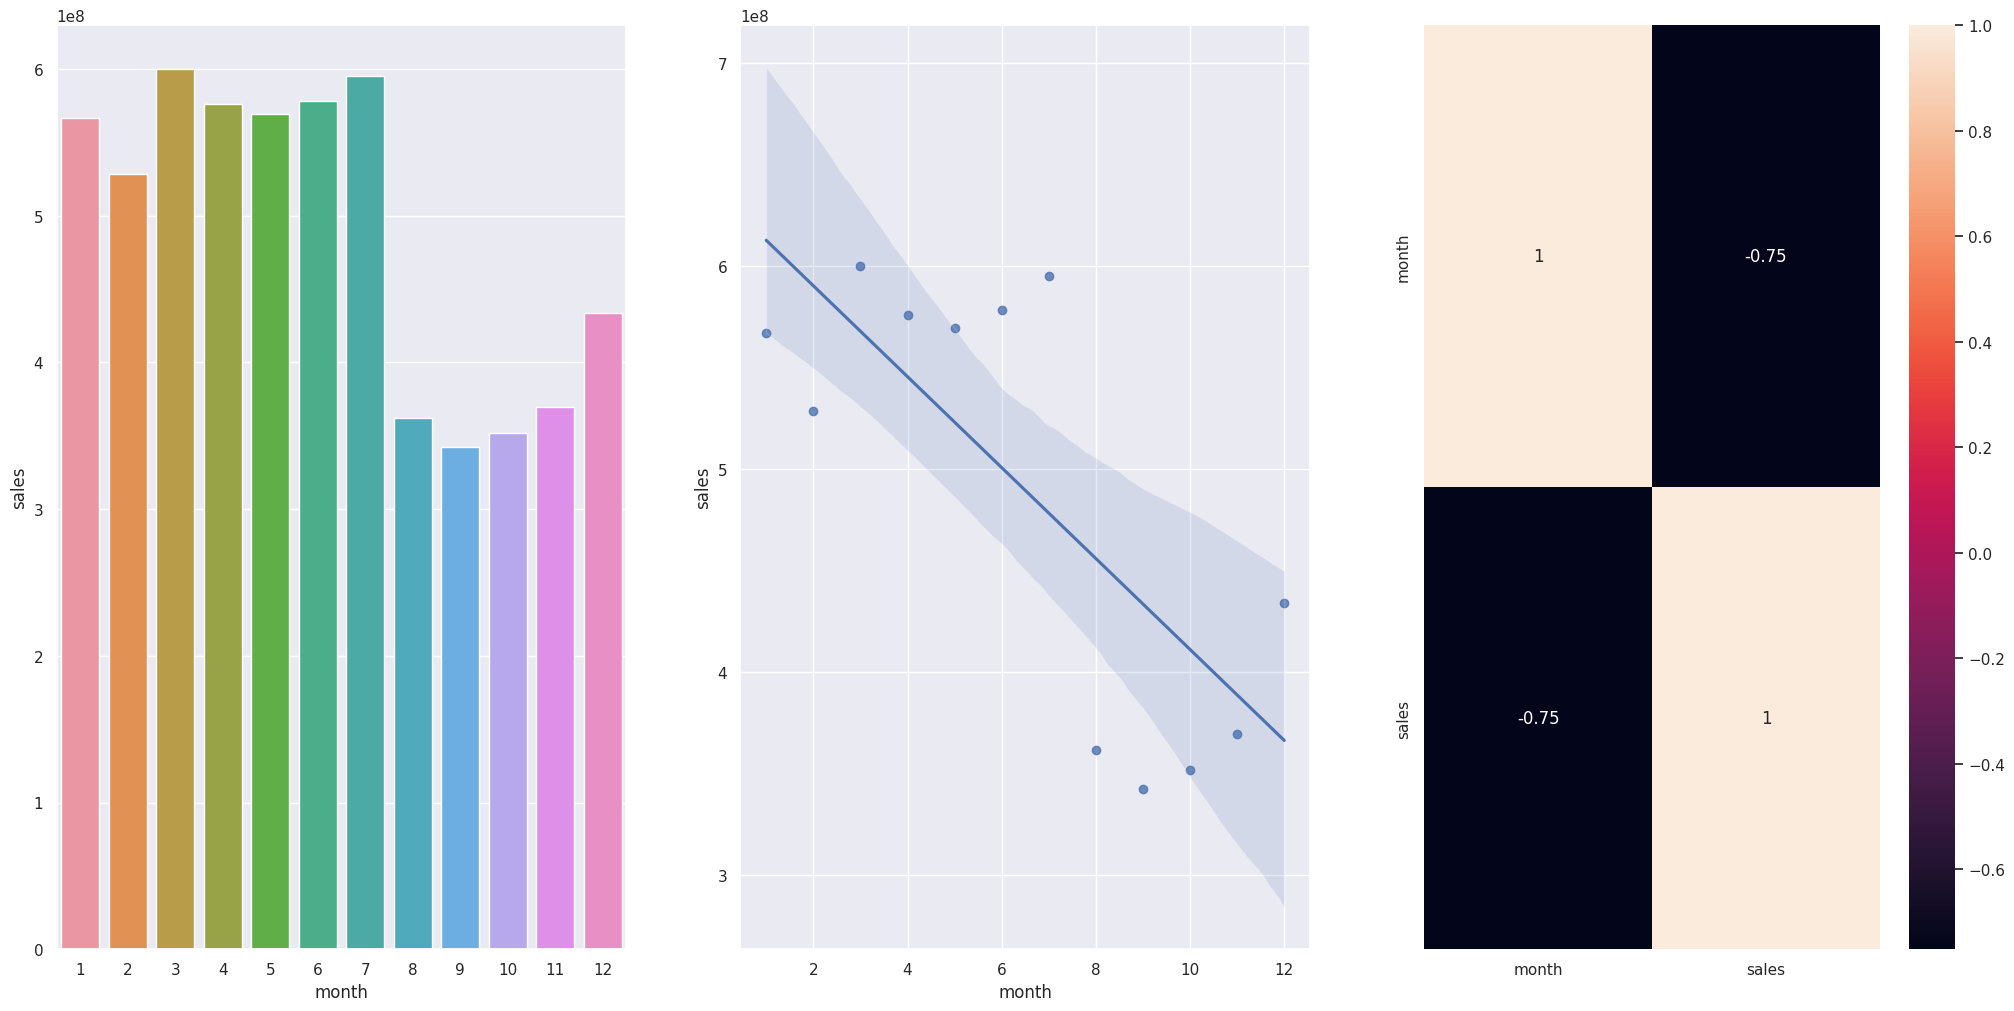

In [55]:
plt.subplot(1,3,1)
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)

sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3,)
sns.heatmap(aux1.corr(method='pearson'), annot=True);




<Axes: xlabel='before_after', ylabel='sales'>

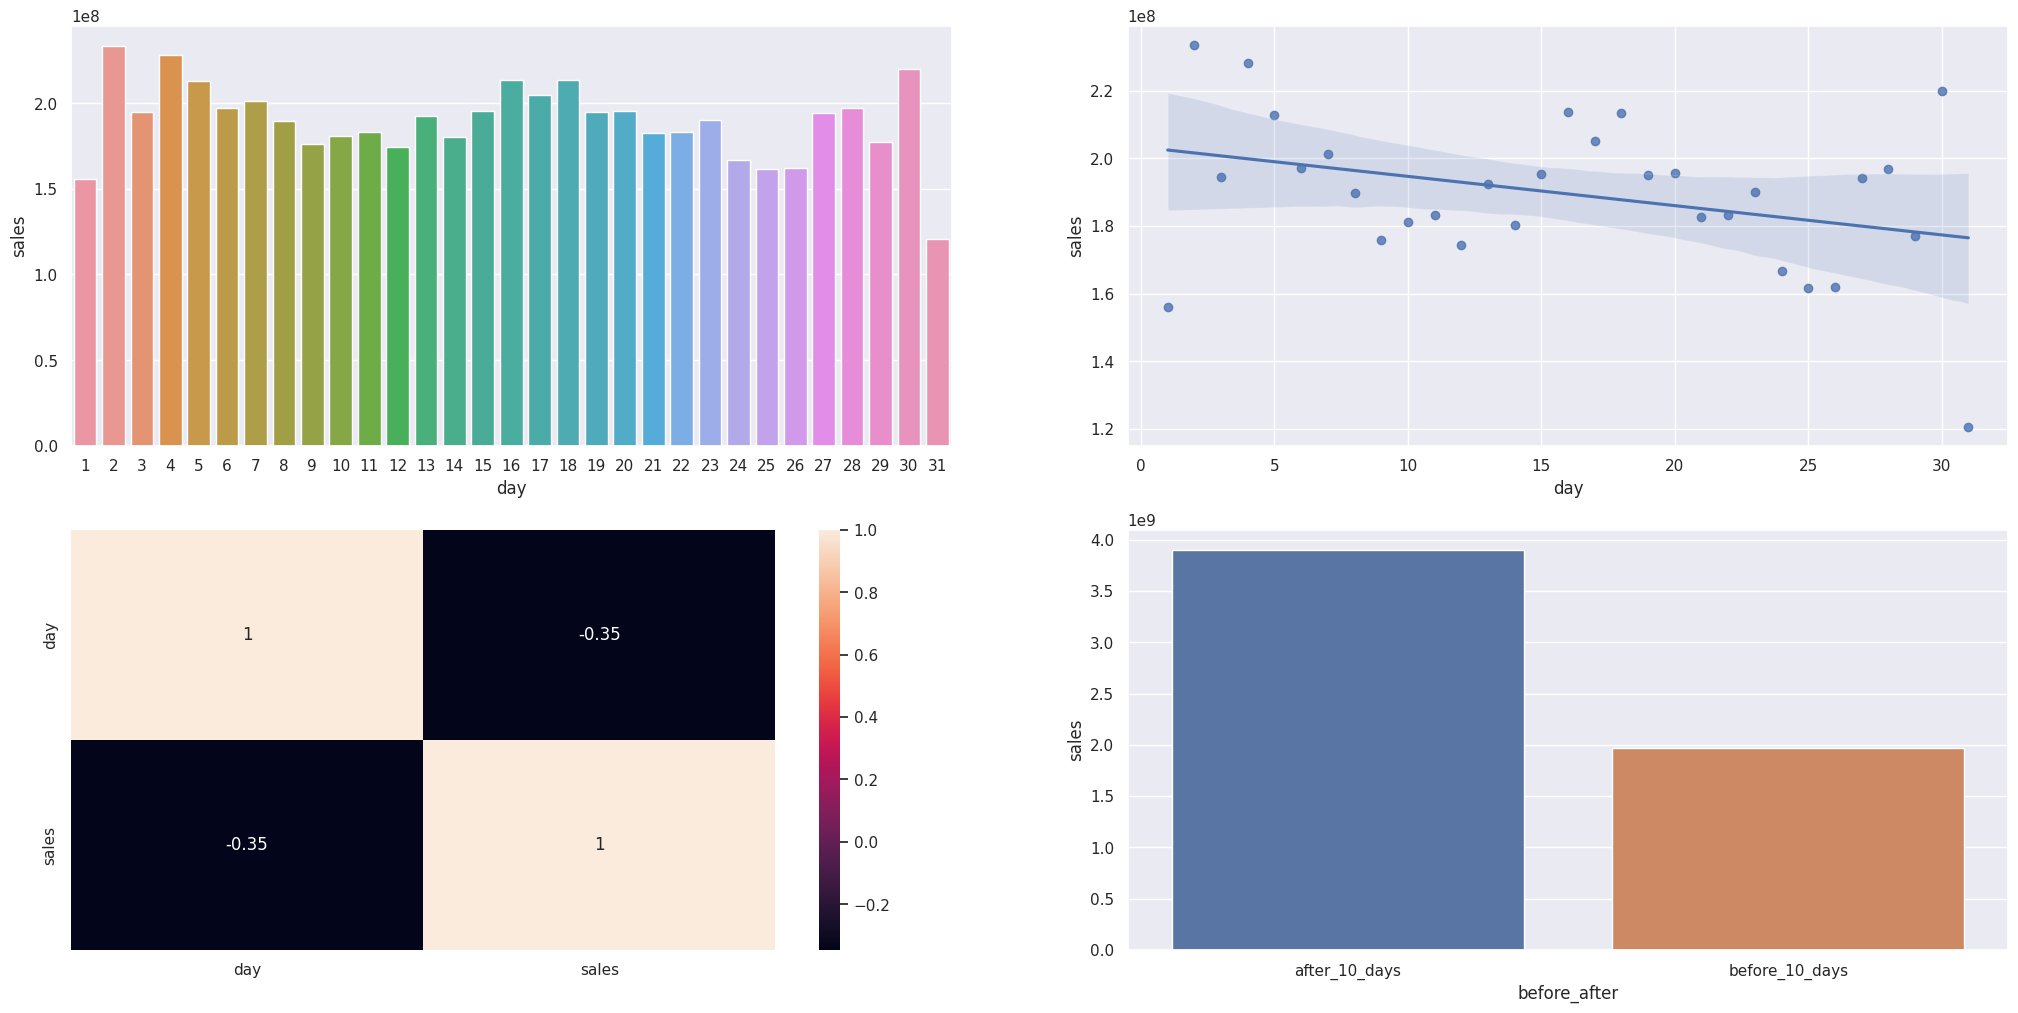

In [56]:
plt.subplot(2,2,1)
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)

sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3,)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

plt.subplot(2,2,4,)
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2)


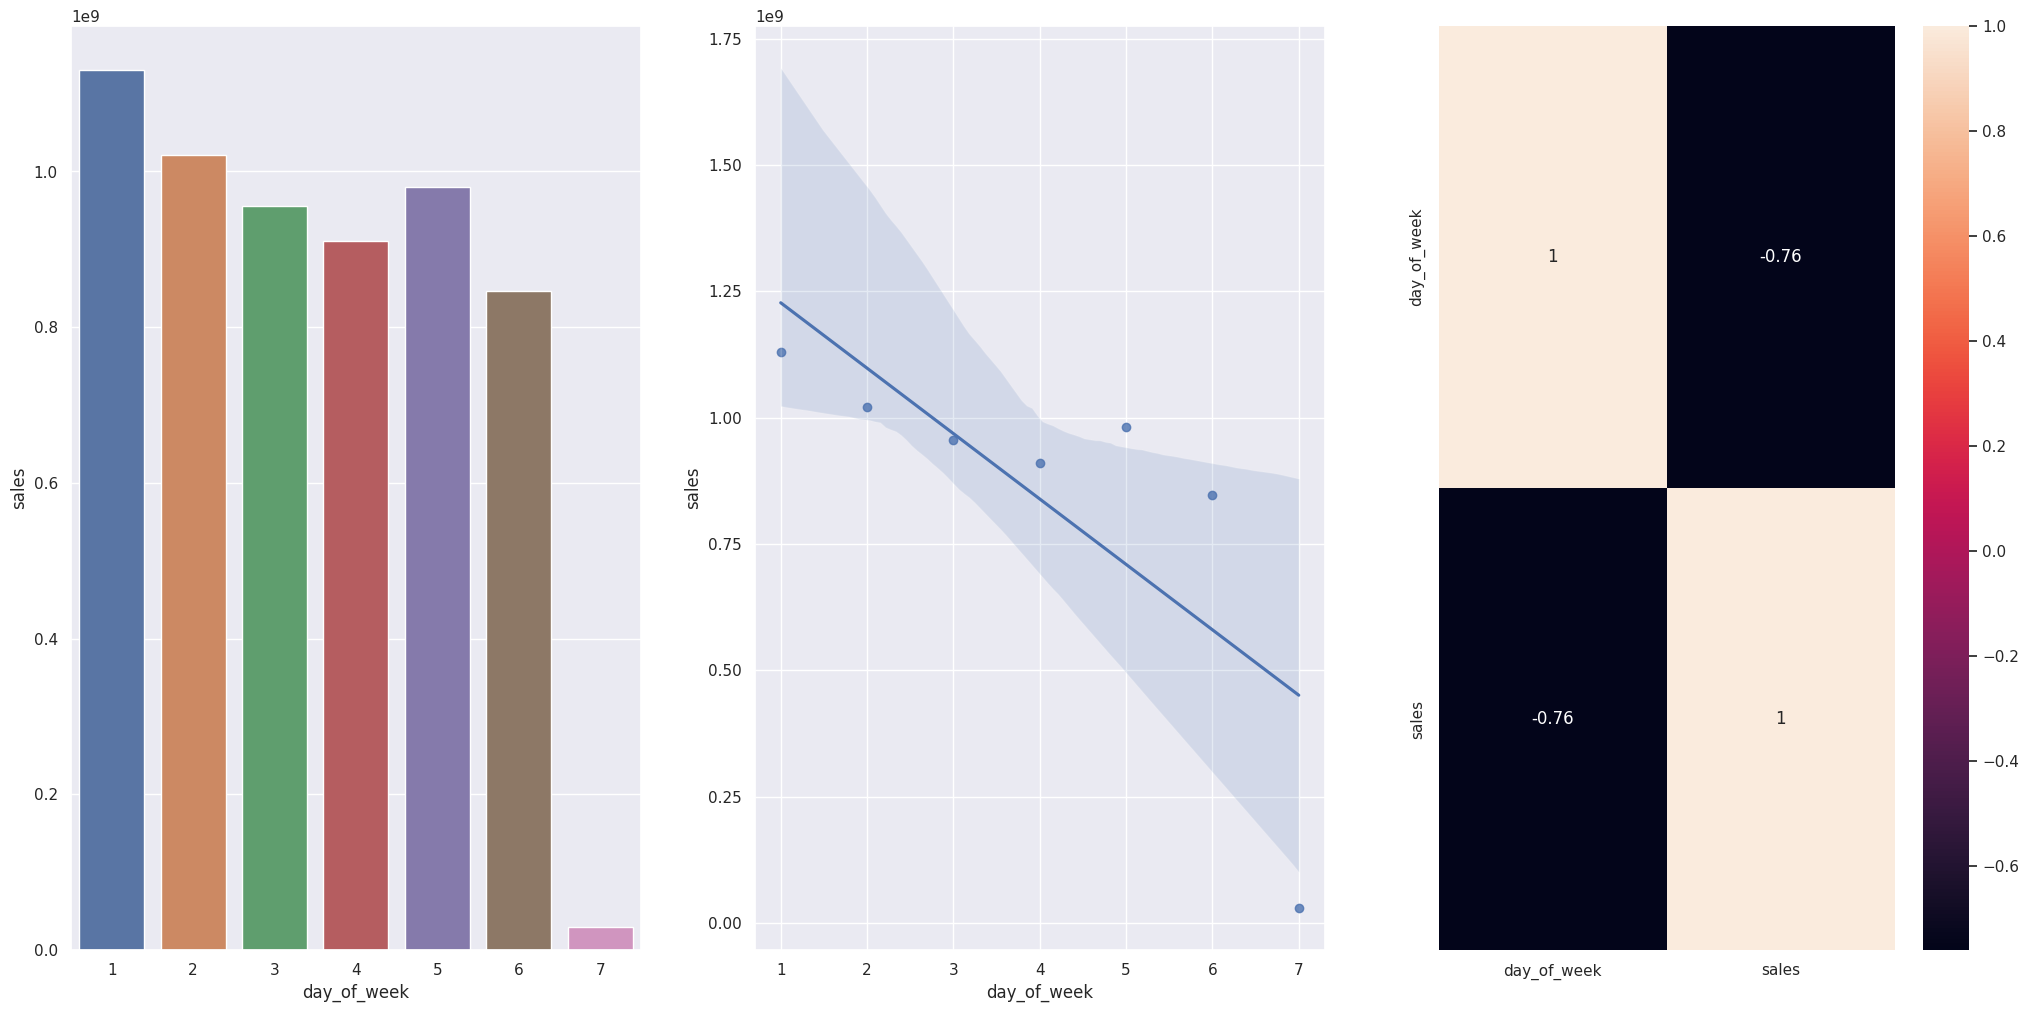

In [57]:
plt.subplot(1,3,1)
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)

sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3,)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


<Axes: xlabel='month', ylabel='sales'>

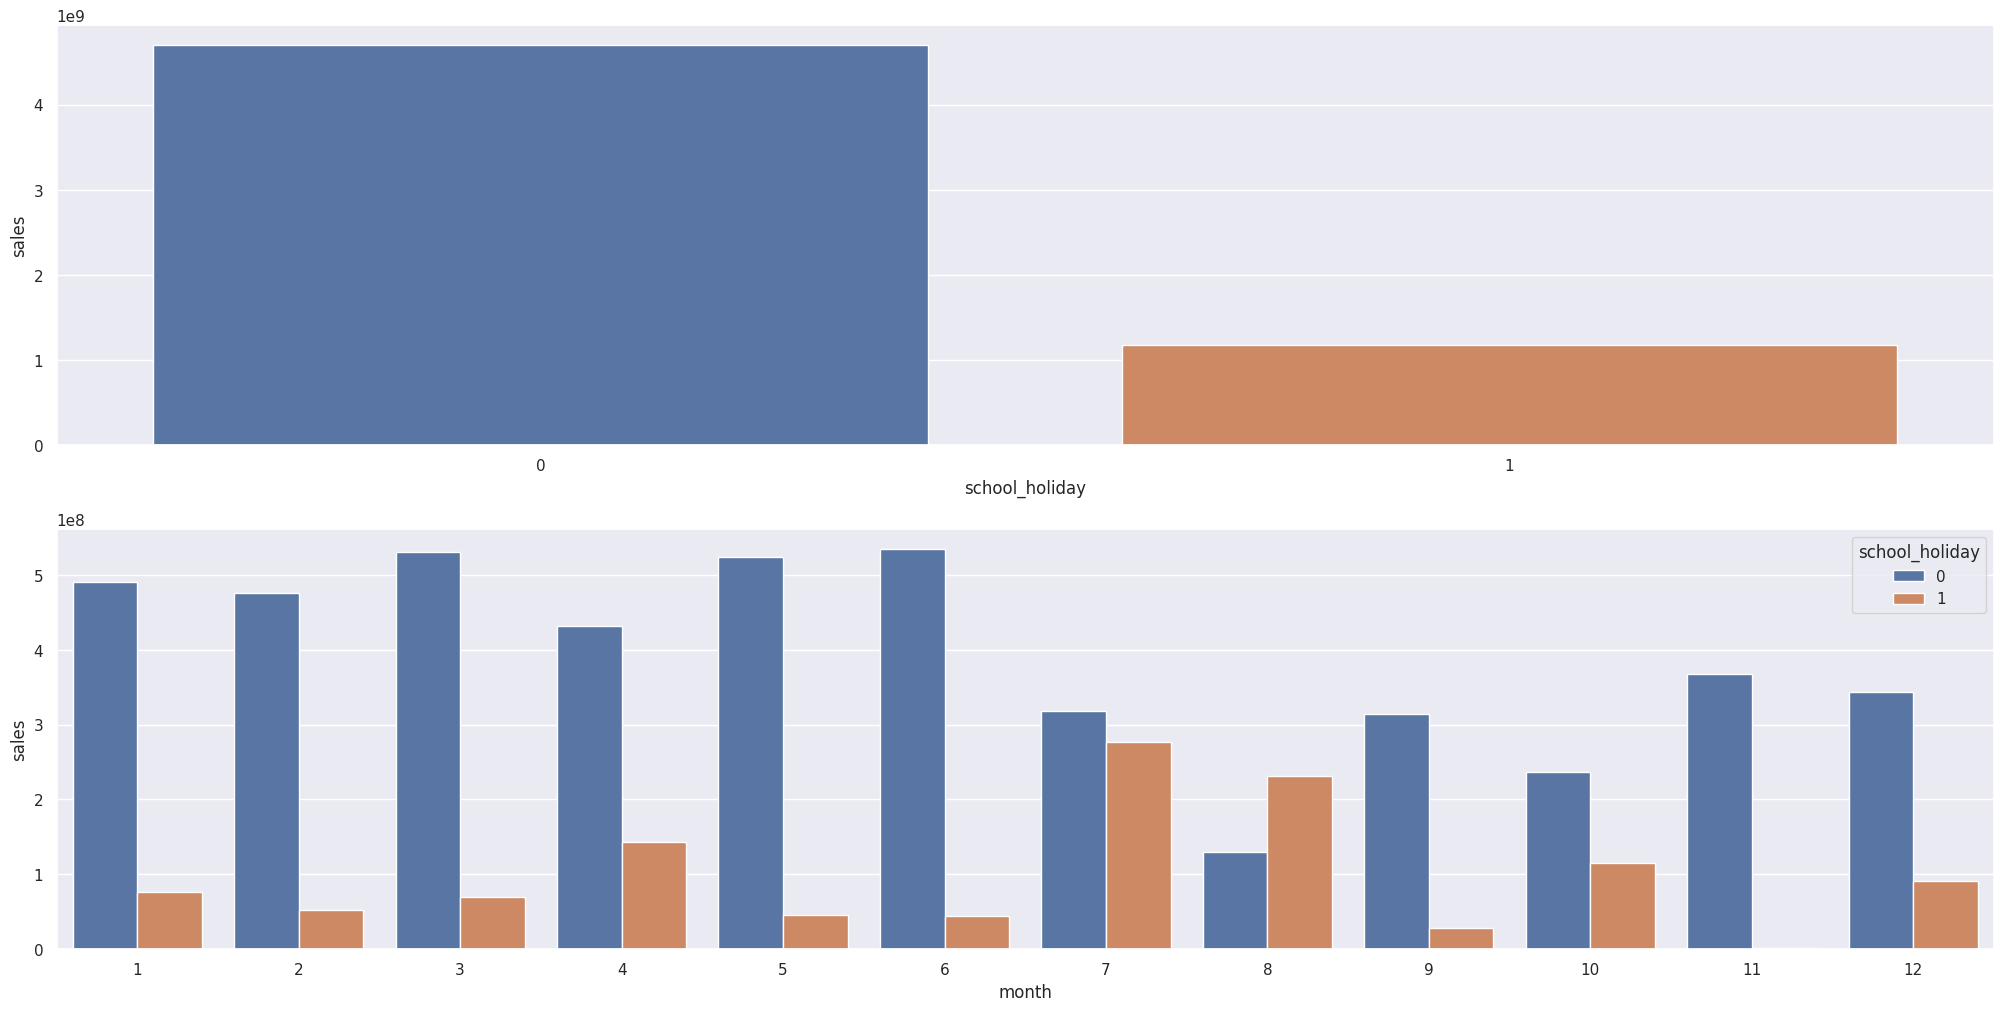

In [58]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)



### 4.2.1 Resumo das Hipoteses

In [59]:
# cols_selected_boruta

In [60]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H7', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical attributes

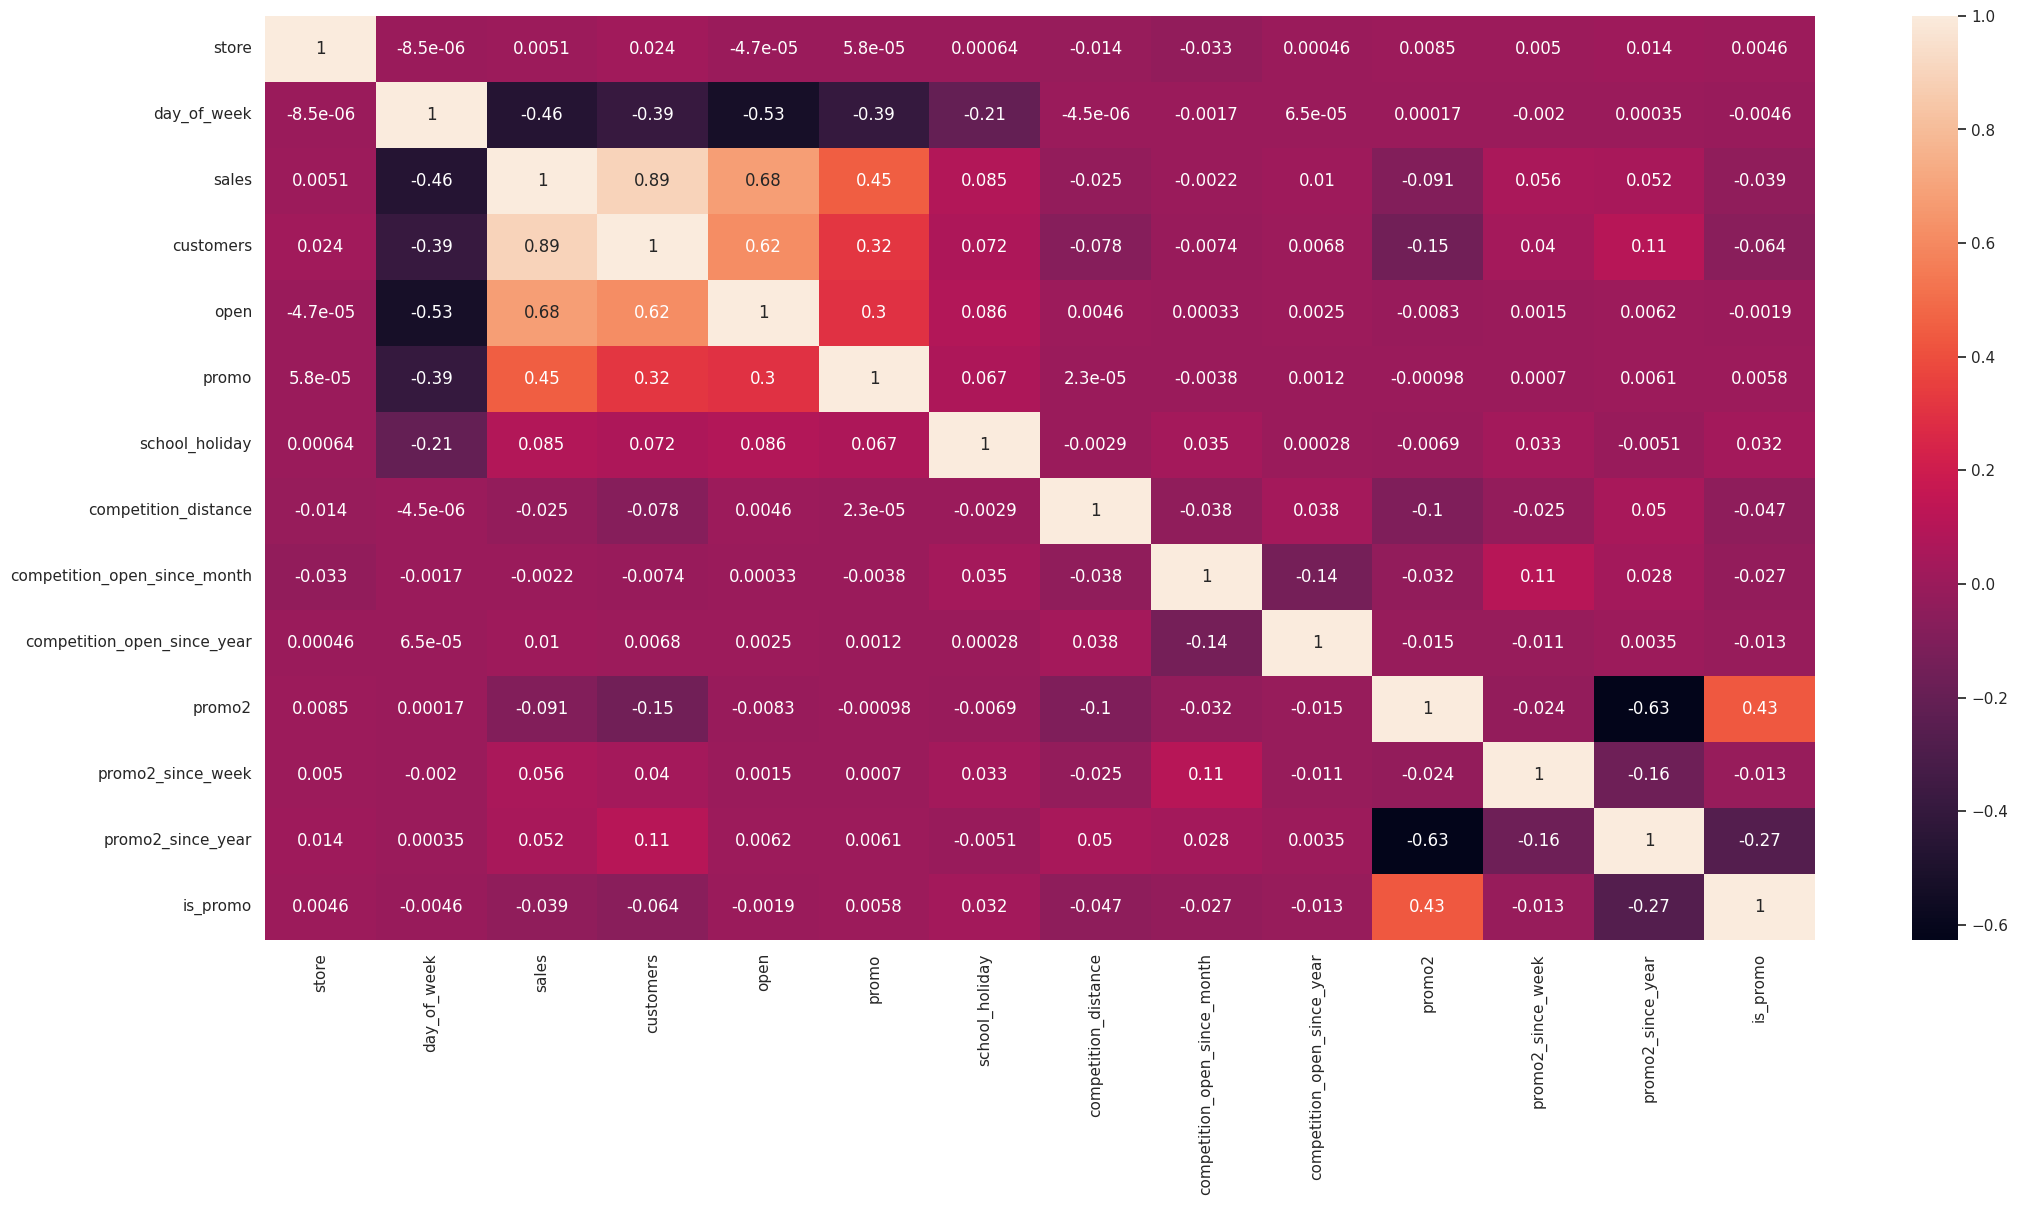

In [61]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 Categorical Attibutes

<Axes: >

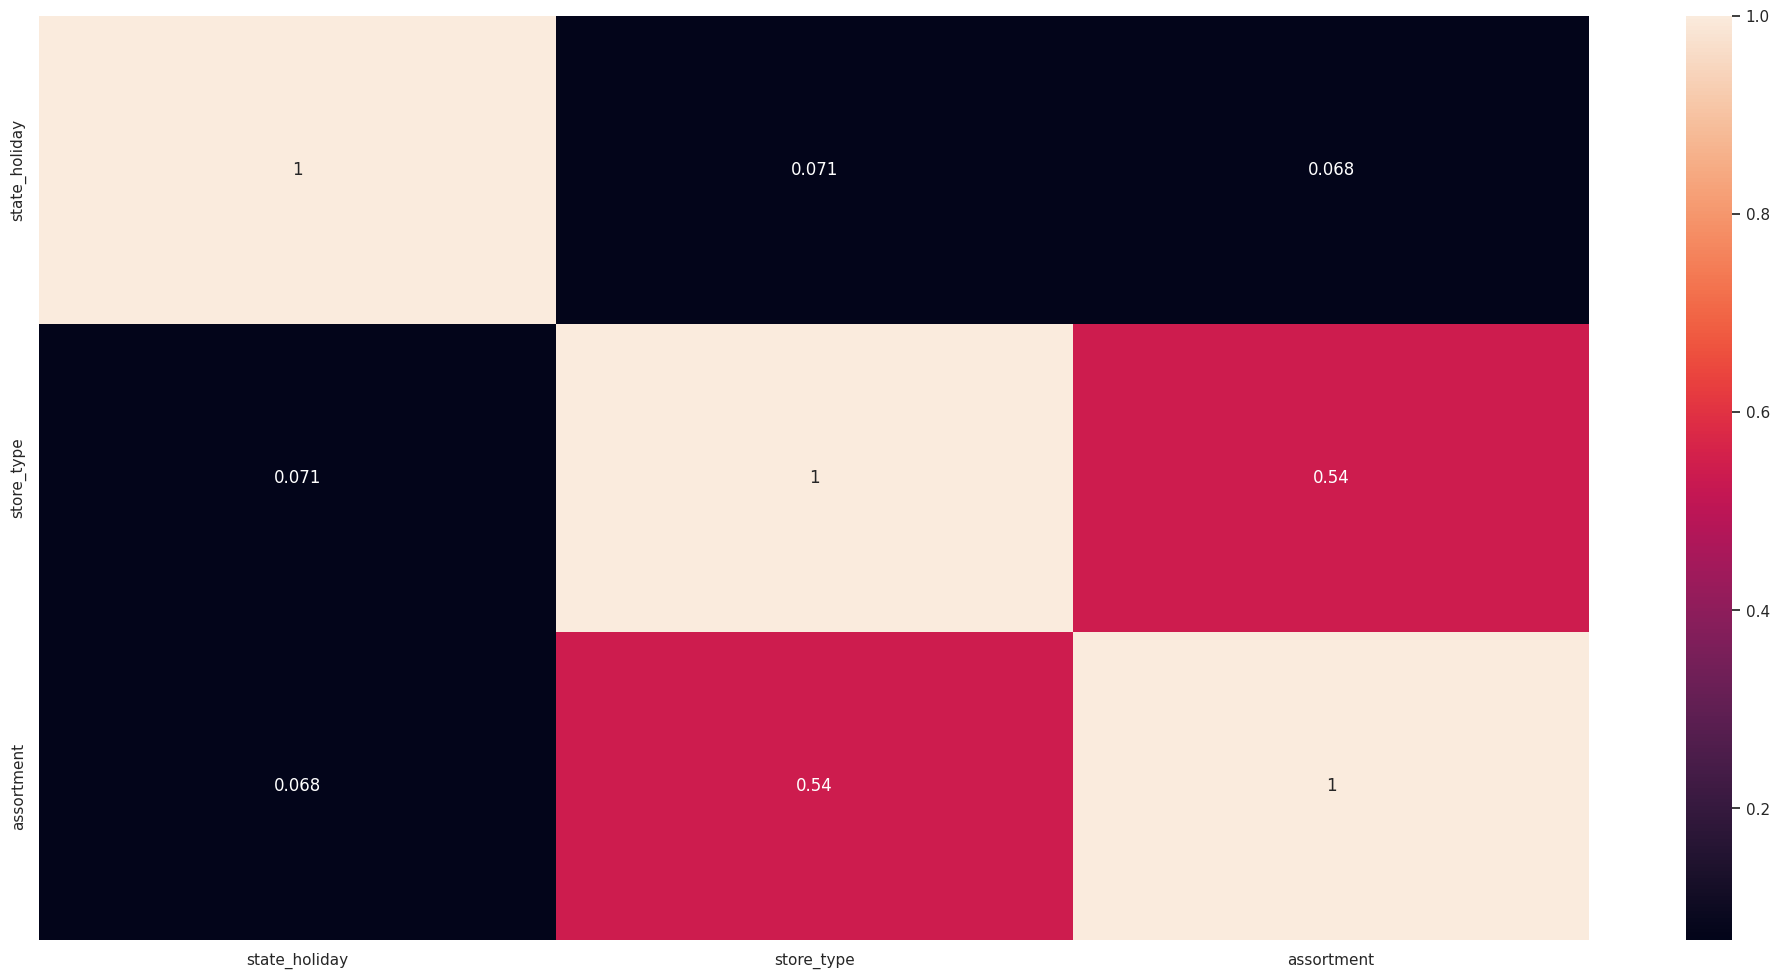

In [62]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9]  })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# Passo 05 - Data Preparation

In [63]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [64]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open('/home/segovia/repos/rosmann_project/parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump(rs, open('/home/segovia/repos/rosmann_project/parameter/competition_time_month_scaler.pkl', 'wb'))


# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(rs, open('/home/segovia/repos/rosmann_project/parameter/promo_time_week_scaler.pkl', 'wb'))


# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(rs, open('/home/segovia/repos/rosmann_project/parameter/year_scaler.pkl', 'wb'))




## 5.3  Tranformação

### 5.3.1 Encoding

In [65]:

# State_holiday - one hot encoding

df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

# Store_type - Label Encoding

le = LabelEncoder()

df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('/home/segovia/repos/rosmann_project/parameter/store_type_scaler.pkl', 'wb'))



# assortment - ordinal encoding

assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [66]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Nature Transformation

In [67]:
# day of week

df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * (2. * np.pi/7)))

# month

df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day

df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year

df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

<Axes: xlabel='competition_distance', ylabel='Density'>

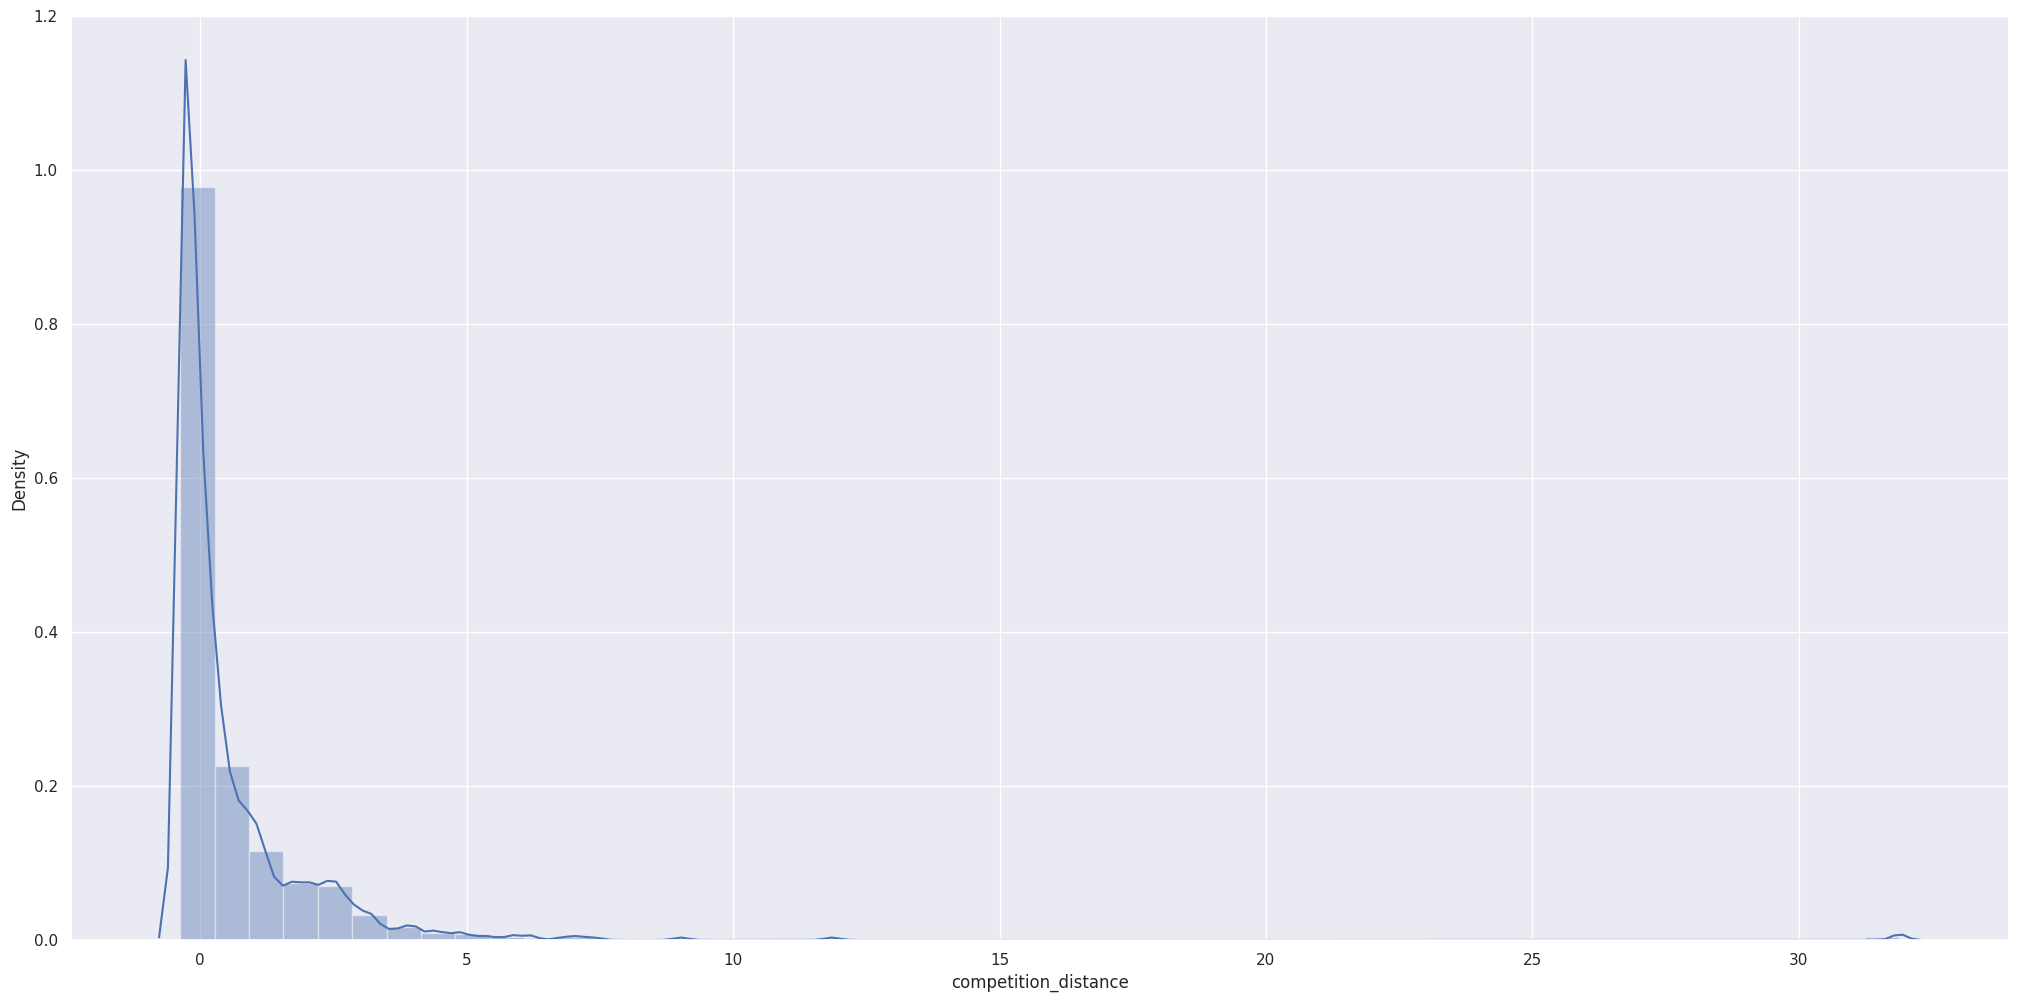

In [68]:
sns.distplot(df5['competition_distance'])

# Passo 06

In [69]:
df6 = df5.copy()

## 6.1 Split datafrema into training and test dataset

In [70]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [71]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print( 'Training min date: {}'.format(X_train['date'].min()))
print( 'Training max date: {}'.format(X_train['date'].max()))

print( '\nTest min date: {}'.format(X_test['date'].min()))
print( 'Test max date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00

Test min date: 2015-06-19 00:00:00
Test max date: 2015-07-31 00:00:00


## 6.2 Boruta as Features selector

In [72]:
# #training and test dataset for boruta
# x_train_n = x_train.drop(['date', 'sales'], axis=1).values
# y_train_n = y_train.values.ravel()

# #define RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# #define Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit( x_train_n, y_train_n)

In [73]:
# cols_selected = boruta.support_.tolist()

# #best features
# x_train_fs = x_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

# #not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## 6.3 Manuel Feature Selection

In [74]:
cols_selected_boruta = ['store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7 Machine learning modelling

In [75]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#time series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Avarege Model

In [76]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

#prediction

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#perfomance

baseline_result = ml_error('Average Model', np.expm1 (Y_test), np.expm1( yhat_baseline))
baseline_result



,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression model

In [77]:
#model
lr = LinearRegression().fit(x_train, Y_train)


#prediction
yhat_lr = lr.predict(x_test)


#performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result




,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1870.265338,0.292297,2678.61434


### 7.2.1 Linear regression Model - Cross Validation

In [78]:
# lr_resalt_cv = cross_validation(x_training, 1, 'Linear Regression', lr, verbose=False)
# lr_resalt_cv

## 7.3 Linear Regression Regularize Model - Lasso

In [79]:
# #model
# lrr = Lasso(alpha=0.01).fit(x_train, Y_train)



# #prediction
# yhat_lrr = lrr.predict(x_test)


# #performance
# lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
# lrr_result

### 7.3.1 Lasso - Cross Validation

In [80]:
# lrr_resalt_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
# lrr_resalt_cv

## 7.4 Random Forest Regressor

In [81]:
# #model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)



# #prediction
# yhat_rf = rf.predict(x_test)


# #performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
# rf_result

### 7.4.1 Random Forest Regressor - Cross Validation

In [82]:
# rf_resalt_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
# rf_resalt_cv

## 7.5 XGBoost Regressor

In [83]:
# #model
# model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                             n_estimators=100,
#                             eta=0.01,
#                             max_depth=10,
#                             subsample=0.7).fit(x_train, Y_train)



# #prediction
# yhat_xgb = model_xgb.predict(x_test)


# #performance
# xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
# xgb_result

### 7.5.1 XGBoost Regressor - Cross Validation

In [84]:
# xgb_resalt_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
# xgb_resalt_cv

### 7.6 Compare Model's Performance

#### 7.6.1 Single Performance

In [85]:
# modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
# modelling_result.sort_values('RMSE')

#### 7.6.1 Real Performance - Cross Validation

In [86]:
# modelling_result_cv = pd.concat([lr_resalt_cv, lrr_resalt_cv, rf_resalt_cv, xgb_resalt_cv ])
# modelling_result_cv

# Passo 08 - Hyperparameter fine tuning

## 8.1 Random Search

In [87]:
# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth': [3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'min_child_weight': [3, 8, 15]      
#         }
# MAX_EVAL = 5

In [88]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):

#     #choose values for parameters randomly
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )


#     #model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'],
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   min_child_weight=hp['min_child_weight'] )



#     #performance
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb,verbose=True )
#     final_result = pd.concat( [final_result, result] )

# final_result

## 8.2 Final Model

In [89]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'min_child_weight': 15
        }

In [90]:
#model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                  n_estimators=param_tuned['n_estimators'],
                                  eta=param_tuned['eta'],
                                  max_depth=param_tuned['max_depth'],
                                  subsample=param_tuned['subsample'],
                                  min_child_weight=param_tuned['min_child_weight'] ).fit(x_train, Y_train)



#prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)


#performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,767.199674,0.115228,1100.759666


In [91]:
mpe = mean_percentage_error( np.expm1( Y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.020234523571109657

In [92]:
pickle.dump(model_xgb_tuned, open( '/home/segovia/repos/rosmann_project/models/model_rossmann.pkl', 'wb'))

# Passo 9 - TRadução e interpetação do erro

In [93]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.1 Business Performance

In [94]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [95]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107264.843750,103841.639186,110688.048314,3423.204564,0.606523
908,909,223609.437500,215814.699219,231404.175781,7794.738281,0.513396
594,595,344092.218750,339088.954009,349095.483491,5003.264741,0.344061
875,876,194231.515625,190180.585938,198282.445312,4050.929688,0.320470
169,170,198439.062500,197179.427470,199698.697530,1259.635030,0.313933


<Axes: xlabel='store', ylabel='MAPE'>

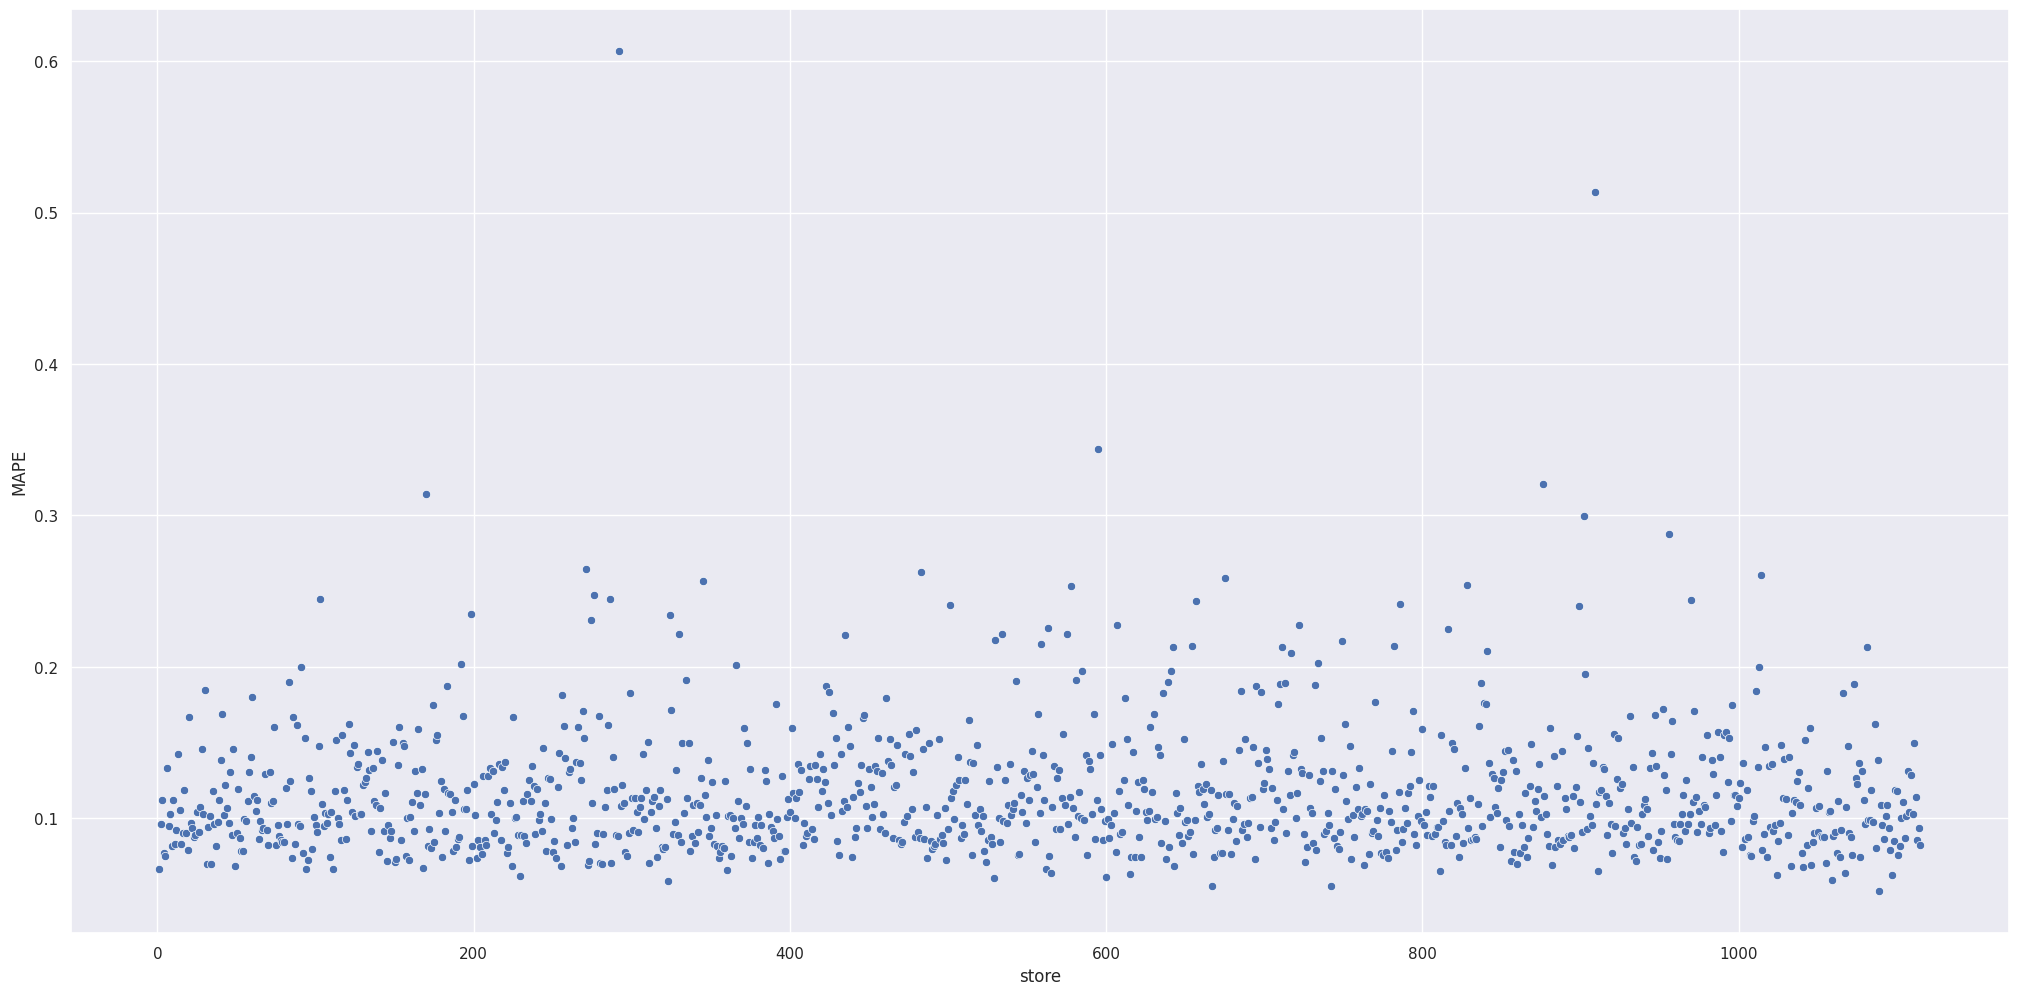

In [96]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2 Total performance

In [97]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x:np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'} )

df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$287,458,112.00"
1,worst_scenario,"R$286,599,481.22"
2,best_scenario,"R$288,316,704.47"


## 9.3 Machine learning Performance

In [98]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<Axes: xlabel='predictions', ylabel='error'>

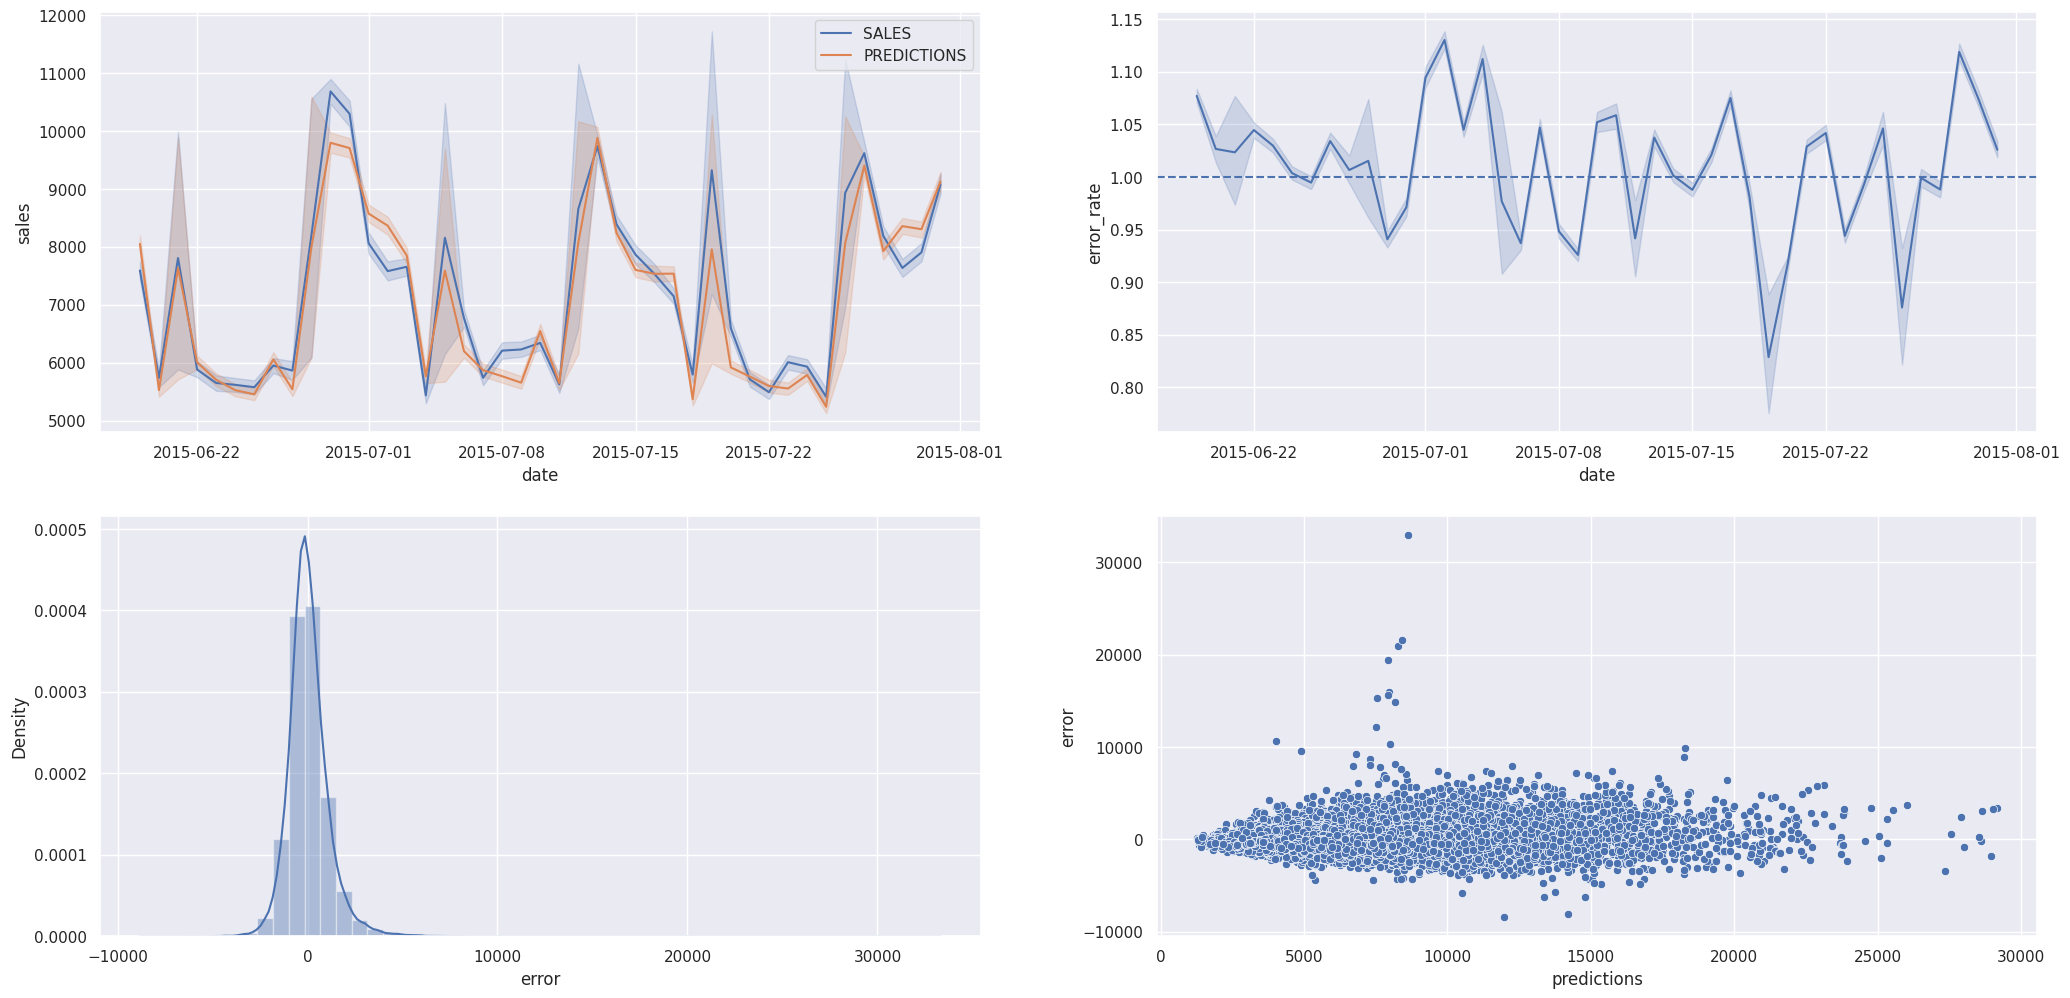

In [99]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x='predictions', y='error', data=df9 )

# Passo 10 - Deploy Model to production

## 10.1 Rossmann Class

In [100]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime
import json



class Rossmann (object):
       def __init__(self) :
              self.home_path = '/home/segovia/repos/rosmann_project/'
              self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
              self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
              self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
              self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
              self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
              
       
       def data_cleaning(self, df1):

              ## 1.1 rename coluns
              cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                     'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                     'CompetitionDistance', 'CompetitionOpenSinceMonth',
                     'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                     'Promo2SinceYear', 'PromoInterval']

              snakecase = lambda x: inflection.underscore(x)

              cols_new = list(map(snakecase, cols_old))

              #rename

              df1.columns = cols_new

              df1['date'] = pd.to_datetime( df1['date'] )


              # competition_distance
              df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

              # competition_open_since_month
              df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

              # competition_open_since_year
              df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)

                                   
              # promo2_since_week
              df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)

              # promo2_since_year
              df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)

              # promo_interval
              month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4:'Apr', 5: 'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

              df1['promo_interval'].fillna(0, inplace=True)

              df1['month_map'] = df1['date'].dt.month.map(month_map)

              df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0, axis=1)

              #competition
              df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
              df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

              #promo2
              df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
              df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

              return df1
       
       
       def feature_engineering (self, df2):


              ## 2.4 Feature Engineering

              #year
              df2['year'] = df2['date'].dt.year

              #month
              df2['month'] = df2['date'].dt.month

              #day
              df2['day'] = df2['date'].dt.day

              #week of year
              df2['week_of_year'] = df2['date'].dt.isocalendar().week

              #year week
              df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

              #competition since
              df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
              df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype( int)
              #promo since

              df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
              df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
              df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days ).astype(int)

              #assortment
              df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

              #state holiday
              df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day' )


              ## 3.2 Filtragem de colunas
              cols_drop = ['open', 'promo_interval', 'month_map']
              df2 = df2.drop(cols_drop, axis=1)

              return df2


       def data_preparation (self, df5 ):


              # competition distance
              df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

              # competition time month
              df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )



              # promo time week
              df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
              

              # year
              df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )


              ### 5.3.1 Encoding

              # State_holiday - one hot encoding

              df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'], dtype=int)

              # Store_type - Label Encoding


              df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])



              # assortment - ordinal encoding

              assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
              df5['assortment'] = df5['assortment'].map(assortment_dict)



              ### 5.3.3 Nature Transformation
              # day of week

              df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin(x * (2. * np.pi/7)))
              df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos(x * (2. * np.pi/7)))

              # month

              df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
              df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

              # day

              df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
              df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

              # week of year

              df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
              df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

              cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance','competition_open_since_month', 'competition_open_since_year', 'promo2','promo2_since_week',
                               'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos', 'day_sin','day_cos', 'week_of_year_sin', 'week_of_year_cos']

              return df5[cols_selected]
       
       def get_prediction (self, model, original_data, test_data):
              #prediction
              pred = model.predict(test_data)

              #join pred into the original data
              original_data['prediction'] = np.expm1(pred)

              return original_data.to_json(orient='records', date_format='iso')




## 10.2 API Handler

In [101]:
import pickle
import pandas as pd
from flask import Flask, request, Response
import requests
from rossmann.Rossmann import Rossmann
import json



#loading model
model = pickle.load(open ('/home/segovia/repos/rosmann_project/models/model_rossmann.pkl', 'rb'))

#initialize API
app = Flask(__name__)

@app.route(  '/rossmann/predict', methods = ['POST'])
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json:

        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])

        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].Keys())

        #instantiate rossmann class
        pipeline = Rossmann()

        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        #feature engineering

        df2 = pipeline.feature_engineering(df1)

        #data preparation

        df3 = pipeline.data_preparation(df2)

        #prediction

        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response




    else:
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)



ModuleNotFoundError: No module named 'rossmann'

## 10.13 API test

In [4]:
df10 = pd.read_csv('data/test.csv', low_memory=False)


In [24]:
# merge
df_test = pd.merge (df10, df_store_raw, how="left", on='Store')

#choose store for pretiction
df_test = df_test[ df_test['Store'].isin([24,12,22])]



df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)


In [25]:
import json 

In [26]:
data = json.dumps(df_test.to_dict(orient='records'))

In [27]:
#api call

url = 'http://localhost:5000/rossmann/predict'
header = {'Content-type': 'application/json'}

r = requests.post(url, data=data, headers=header)
print('status code {}'.format(r.status_code))


status code 200


In [28]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [29]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,12,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000,0,2010-03-22T00:00:00.000,286,6159.875000
1,22,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,17,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,3983.388672
2,24,4,2015-09-17T00:00:00.000,1.0,1,regular_day,0,a,extended,4590.0,...,2015,9,17,38,2015-37,2000-03-01T00:00:00.000,189,2011-09-26T00:00:00.000,207,7560.740723
3,12,3,2015-09-16T00:00:00.000,1.0,1,regular_day,0,a,extended,1070.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000,0,2010-03-22T00:00:00.000,286,6266.666016
4,22,3,2015-09-16T00:00:00.000,1.0,1,regular_day,0,a,basic,1040.0,...,2015,9,16,38,2015-37,2015-09-01T00:00:00.000,0,2012-05-21T00:00:00.000,173,4114.970703


In [30]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()


for i in range(len(d2)):
    print('|Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(
            d2.loc[i,'store'],
            d2.loc[i, 'prediction'] ))


|Store Number 12 will sell R$236,079.18 in the next 6 weeks
|Store Number 22 will sell R$145,370.20 in the next 6 weeks
|Store Number 24 will sell R$287,068.94 in the next 6 weeks


In [22]:
d2

,store,prediction
0,22,155668.535278
